# Second-Order Action-Conditioned Trajectory Matching


In [2]:
import torch

torch.exp(torch.tensor(-1))

tensor(0.3679)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm


# ==========================================
# 1. PHYSICS ENGINE (Ground Truth)
# ==========================================
class ForcedOscillator:
    def __init__(self, m=1.0, k=1.0, force_range=(-10, 10)):
        self.m, self.k = m, k
        self.force_range = force_range
        # Map Action Index -> Force Value
        self.force_map = {0: -1.0, 1: 0.0, 2: 1.0}  # Left, None, Right

    def step(self, state, c, action_idx, dt=0.1):
        """
        Precise integration of the ground truth physics
        state: [x, v]
        """
        f_val = self.force_map[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0], s[..., 1]
            dxdt = v
            # m*a = F_action - c*v - k*x
            dvdt = (f_val - (self.k * x) - (c * v)) / self.m
            return torch.stack([dxdt, dvdt], dim=-1)

        # Integrate exactly one step
        next_state = odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]
        return next_state


# ==========================================
# 2. DATASET (Sequence Generation)
# ==========================================
class SequenceDataset(Dataset):
    def __init__(
        self,
        n_seqs=200,
        seq_len=20,
        dt=0.1,
        m=1.0,
        k=1.0,
        force_range=(-10, 10),
        c_range=(0.1, 2.0),
    ):
        self.data = []
        physics = ForcedOscillator(m=m, k=k, force_range=force_range)

        print(f"Generating {n_seqs} sequences of length {seq_len}...")

        for _ in range(n_seqs):
            # Randomize Damping per sequence to force model to generalize
            c = np.random.uniform(c_range[0], c_range[1])
            state = torch.tensor([np.random.uniform(-1, 1), 0.0])

            states = [state]
            actions = []

            # Generate Sequence
            for _ in range(seq_len):
                a = np.random.randint(0, 3)
                state = physics.step(state, c, a, dt)
                states.append(state)
                actions.append(a)

            # Store: (States[0:T], Actions[0:T], States[1:T+1])
            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),  # Inputs
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),  # Next steps
                    "c": c,
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline: Discrete Jump Model (ResNet) ---
class JumpModel(nn.Module):
    """
    Learns x_{t+1} = x_t + f(x_t, a_t)
    Approximates dynamics as a discrete map (Chord).
    """

    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)
        self.net = nn.Sequential(
            nn.Linear(state_dim + 8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, state_dim),  # Outputs Delta State
        )

    def forward(self, state, action):
        emb = self.act_emb(action)
        delta = self.net(torch.cat([state, emb], dim=-1))
        return state + delta


class LSTMModel(nn.Module):
    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)
        self.lstm = nn.LSTM(state_dim + 8, 64, batch_first=True)
        self.fc = nn.Linear(64, state_dim)

    def forward(self, state, action):
        emb = self.act_emb(action)
        x = torch.cat([state, emb], dim=-1)
        x, _ = self.lstm(x)
        return state + self.fc(x)


# --- Proposed: Second-Order ODE with Prior ---
class SecondOrderODENet(nn.Module):
    """
    Learns d/dt[x, v] = [v, Prior(a) + NN(x, v, a)]
    """

    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)

        # Neural Correction Term
        self.net = nn.Sequential(
            nn.Linear(state_dim + 8, 64),
            nn.Tanh(),  # Tanh is better for continuous physics
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),  # Output: Acceleration Correction
        )

        # Learnable weighting for the prior (optional)
        # self.prior_scale = nn.Parameter(torch.tensor(1.0))

    def physics_prior(self, state, action_idx):
        """
        Rough Draft Physics: F = Action_Force - Damping*v
        We assume we don't know 'k' (spring constant) or exact 'c'.
        """
        v = state[..., 1:2]

        # Simple mapping: 0->-1, 1->0, 2->1
        force_vals = torch.tensor([-1.0, 0.0, 1.0], device=state.device)
        f_action = force_vals[action_idx].unsqueeze(-1)

        # Prior: Input force + some default damping
        return f_action - 0.1 * v

    def forward(self, t, state, action_emb, action_idx):
        x, v = state[..., 0:1], state[..., 1:2]

        # 1. Analytic Prior (The "Bending" Force)
        # prior_acc = self.physics_prior(state, action_idx)

        # 2. Neural Correction
        nn_input = torch.cat([x, v, action_emb], dim=-1)
        correction_acc = self.net(nn_input)

        # 3. Total Acceleration
        # We start with the prior, NN fixes the errors
        # total_acc = (self.prior_scale * prior_acc) + correction_acc
        total_acc = correction_acc

        return torch.cat([v, total_acc], dim=-1)


# Wrapper to handle ODESolve logic
class TrajectoryMatchingModel(nn.Module):
    def __init__(self, ode_func):
        super().__init__()
        self.ode_func = ode_func

    def forward(self, start_state, action_indices, dt=0.1):
        """
        Integrates one step forward using the ODE solver.
        Note: For training, we can integrate K steps if we want.
        """
        # We need to handle the embedding lookup here to pass to ODE func
        act_emb = self.ode_func.act_emb(action_indices)

        # Define dynamics closure for torchdiffeq
        # Note: torchdiffeq expects func(t, y)
        def func(t, y):
            return self.ode_func(t, y, act_emb, action_indices)

        # Integrate from t=0 to t=dt
        # Using RK4 for stability in training
        t_span = torch.tensor([0.0, dt], device=start_state.device)
        next_state = odeint(func, start_state, t_span, method="rk4")[-1]

        return next_state


class FirstOrderODENet(nn.Module):
    """
    Learns d/dt[x] = Prior(a) + NN(x, a)
    First-order model: only tracks position, predicts velocity directly
    """

    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)

        # Neural Correction Term
        self.net = nn.Sequential(
            nn.Linear(state_dim + 8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),  # Output: Velocity Correction
        )

        # Learnable weighting for the prior (optional)
        self.prior_scale = nn.Parameter(torch.tensor(1.0))

    def physics_prior(self, state, action_idx):
        """
        Rough Draft Physics: v = Action_Velocity - Damping*x
        For first-order, we assume velocity is directly related to action
        """
        x = state[..., 0:1]

        # Simple mapping: 0->-1, 1->0, 2->1 (velocity from action)
        velocity_vals = torch.tensor([-1.0, 0.0, 1.0], device=state.device)
        v_action = velocity_vals[action_idx].unsqueeze(-1)

        # Prior: Action velocity + some default restoring force (like spring)
        return v_action - 0.1 * x

    def forward(self, t, state, action_emb, action_idx):

        # 1. Analytic Prior (The "Bending" Velocity)
        # prior_vel = self.physics_prior(state, action_idx)

        # 2. Neural Correction
        nn_input = torch.cat([state, action_emb], dim=-1)
        correction_vel = self.net(nn_input)

        # 3. Total Velocity
        # We start with the prior, NN fixes the errors
        # total_vel = (self.prior_scale * prior_vel) + correction_vel

        return torch.cat(
            [correction_vel, torch.zeros_like(correction_vel)], dim=-1
        )


# Wrapper to handle ODESolve logic for first-order
class FirstOrderTrajectoryModel(nn.Module):
    def __init__(self, ode_func):
        super().__init__()
        self.ode_func = ode_func

    def forward(self, start_state, action_indices, dt=0.1):
        """
        Integrates one step forward using the ODE solver.
        start_state: [Batch, 1] (position only)
        Returns: [Batch, 1] (next position)
        """
        # Handle embedding lookup
        act_emb = self.ode_func.act_emb(action_indices)

        # Define dynamics closure for torchdiffeq
        def func(t, y):
            return self.ode_func(t, y, act_emb, action_indices)

        # Integrate from t=0 to t=dt
        t_span = torch.tensor([0.0, dt], device=start_state.device)
        next_state = odeint(func, start_state, t_span, method="rk4")[-1]

        return next_state


class PortHamiltonianModel(nn.Module):
    def __init__(self, state_dim=2, action_dim=3):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 8)

        self.H_net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1),
        )

        # self.R_net = nn.Sequential(
        #     nn.Linear(state_dim, 64),
        #     nn.Tanh(),
        #     nn.Linear(64, state_dim // 2),
        #     nn.Softplus(),
        # )
        # self.R = nn.Parameter(torch.tensor(0.1))
        self.R = torch.tensor(0.0)

        # 4. Input Port (G)
        self.G_net = nn.Linear(8, state_dim // 2)

    def forward(self, t, state, action_emb, action_idx):
        if not state.requires_grad:
            state.requires_grad_(True)

        with torch.enable_grad():
            H = self.H_net(state)
            dH_dstate = torch.autograd.grad(
                H, state, torch.ones_like(H), create_graph=True
            )[0]
            dH_dq, dH_dp = dH_dstate[..., 0:1], dH_dstate[..., 1:2]

        # dissipation
        # R = self.R_net(state)
        R = torch.abs(self.R)

        # external force
        G_u = self.G_net(action_emb)  # Shape: [Batch, 1]

        # dynamics
        dq_dt = dH_dp
        dp_dt = -dH_dq - (R * dH_dp) + G_u

        return torch.cat([dq_dt, dp_dt], dim=-1)


# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_experiment(
    dataset, epochs=40, batch_size=32, lr=1e-3, verbose=False
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Models
    jump_model = JumpModel()
    lstm_model = LSTMModel()

    ode_core = SecondOrderODENet()
    traj_model = TrajectoryMatchingModel(ode_core)

    # First-order model
    first_order_ode = FirstOrderODENet()
    # first_order_model = FirstOrderTrajectoryModel(first_order_ode)
    first_order_model = TrajectoryMatchingModel(first_order_ode)

    # Port Hamiltonian model
    port_hamiltonian_ode = PortHamiltonianModel()
    port_hamiltonian_model = TrajectoryMatchingModel(port_hamiltonian_ode)

    opt_jump = optim.Adam(jump_model.parameters(), lr=lr)
    opt_traj = optim.Adam(traj_model.parameters(), lr=lr)
    opt_lstm = optim.Adam(lstm_model.parameters(), lr=lr)
    opt_first = optim.Adam(first_order_model.parameters(), lr=lr)
    opt_port_hamiltonian = optim.Adam(
        port_hamiltonian_model.parameters(), lr=lr
    )

    def train_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        # --- 1. Train Jump Model (One-Step MSE) ---
        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        opt_jump.zero_grad()
        loss_j.backward()
        opt_jump.step()

        opt_lstm.zero_grad()
        loss_lstm.backward()
        opt_lstm.step()

        # --- 2. Train Trajectory Models (Sequential Shooting) ---
        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        opt_traj.zero_grad()
        loss_t.backward()
        opt_traj.step()

        # --- 3. Train First-Order Model ---
        # Extract only position from states [B*T, 2] -> [B*T, 1]
        # flat_pos = flat_s[:, 0:1]  # [B*T, 1] - position only
        # flat_t_pos = flat_t[:, 0:1]  # [B*T, 1] - target position only
        flat_pos = flat_s
        flat_t_pos = flat_t

        pred_first = first_order_model(flat_pos, flat_a, dt=0.1)
        loss_first = ((pred_first - flat_t_pos) ** 2).mean()

        opt_first.zero_grad()
        loss_first.backward()
        opt_first.step()

        # --- 4. Train Port Hamiltonian Model ---
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        opt_port_hamiltonian.zero_grad()
        loss_port_hamiltonian.backward()
        opt_port_hamiltonian.step()

        return loss_j, loss_t, loss_lstm, loss_first, loss_port_hamiltonian

    @torch.no_grad()
    def test_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        # # First-order model
        # flat_pos = flat_s[:, 0:1]
        # flat_t_pos = flat_t[:, 0:1]
        flat_pos = flat_s
        flat_t_pos = flat_t
        pred_first = first_order_model(flat_pos, flat_a, dt=0.1)
        loss_first = ((pred_first - flat_t_pos) ** 2).mean()

        # Port Hamiltonian model
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        return loss_j, loss_t, loss_lstm, loss_first, loss_port_hamiltonian

    print("Training Models...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {1} | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | First: 0.0000, PHNN: 0.0000",
    )
    for epoch in range(1, epochs + 1):
        total_j, total_t, total_lstm, total_first, total_port_hamiltonian = (
            0,
            0,
            0,
            0,
            0,
        )

        for batch in train_loader:
            loss_j, loss_t, loss_lstm, loss_first, loss_port_hamiltonian = (
                train_step(batch)
            )
            total_j += loss_j.item()
            total_t += loss_t.item()
            total_lstm += loss_lstm.item()
            total_first += loss_first.item()
            total_port_hamiltonian += loss_port_hamiltonian.item()

        epoch_loss_j = total_j / len(train_loader)
        epoch_loss_t = total_t / len(train_loader)
        epoch_loss_lstm = total_lstm / len(train_loader)
        epoch_loss_first = total_first / len(train_loader)
        epoch_loss_port_hamiltonian = total_port_hamiltonian / len(
            train_loader
        )
        pbar.set_description(
            f"Epoch {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | First: {epoch_loss_first:.4f}, PHNN: {epoch_loss_port_hamiltonian:.4f}"
        )
        if verbose:
            print(
                f"Ep {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | First: {epoch_loss_first:.4f} | PHNN: {epoch_loss_port_hamiltonian:.4f}",
                flush=True,
            )

    # test set
    print("Testing Models...")
    total_j, total_t, total_lstm, total_first, total_port_hamiltonian = (
        0,
        0,
        0,
        0,
        0,
    )
    for batch in test_loader:
        loss_j, loss_t, loss_lstm, loss_first, loss_port_hamiltonian = (
            test_step(batch)
        )
        total_j += loss_j.item()
        total_t += loss_t.item()
        total_lstm += loss_lstm.item()
        total_first += loss_first.item()
        total_port_hamiltonian += loss_port_hamiltonian.item()

    test_loss_j = total_j / len(test_loader)
    test_loss_t = total_t / len(test_loader)
    test_loss_lstm = total_lstm / len(test_loader)
    test_loss_first = total_first / len(test_loader)
    test_loss_port_hamiltonian = total_port_hamiltonian / len(test_loader)
    print(
        f"Test | Jump: {test_loss_j:.4f} | Traj: {test_loss_t:.4f} | LSTM: {test_loss_lstm:.4f} | First: {test_loss_first:.4f} | PHNN: {test_loss_port_hamiltonian:.4f}"
    )

    return (
        jump_model,
        traj_model,
        lstm_model,
        first_order_model,
        port_hamiltonian_model,
    )


def compute_energy(states, m=1.0, k=1.0):
    """
    Compute Hamiltonian energy from state predictions.

    Args:
        states: [T, 2] array where states[:, 0] = position, states[:, 1] = velocity
        m: mass (default 1.0)
        k: spring constant (default 1.0)

    Returns:
        energies: [T] array of energy values
    """
    x = states[:, 0]
    v = states[:, 1]
    kinetic = 0.5 * m * v**2
    potential = 0.5 * k * x**2
    return kinetic + potential


# ==========================================
# 5. VISUALIZATION (UNROLL)
# ==========================================
def visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.3,
    force_range=(-10, 10),
    history_len=4,
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Warmup History
    state = torch.tensor([1.0, 0.0])
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj = state.unsqueeze(0)
    curr_port_hamiltonian = state.unsqueeze(0)

    # Initialize LSTM history buffer
    lstm_state_buffer = [state.unsqueeze(0)] * history_len
    lstm_action_buffer = [torch.tensor([1])] * history_len

    # Initialize first-order model (position only)
    # curr_first = state[0:1].unsqueeze(0)  # [1, 1] - just position
    curr_first = state.unsqueeze(0)

    # 2. Define Action Sequence
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    (
        gt_hist,
        jump_hist,
        traj_hist,
        lstm_hist,
        first_hist,
        port_hamiltonian_hist,
    ) = ([], [], [], [], [], [])

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, c, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Matching Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            traj_hist.append(curr_traj[0].numpy())

        # D. LSTM Step - Use history buffer
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            lstm_hist.append(curr_lstm[0].numpy())

            # Update history buffer
            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

        # E. First-Order Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_first = first_order_model(curr_first, act_tensor, dt=dt)
            # Convert to [x, 0] format for plotting (velocity is not tracked)
            # first_state = torch.cat(
            #     [curr_first, torch.zeros_like(curr_first)], dim=-1
            # )
            first_state = curr_first
            first_hist.append(first_state[0].numpy())

        # F. Port Hamiltonian Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            port_hamiltonian_hist.append(curr_port_hamiltonian[0].numpy())

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_hist = np.array(traj_hist)
    lstm_hist = np.array(lstm_hist)
    first_hist = np.array(first_hist)
    port_hamiltonian_hist = np.array(port_hamiltonian_hist)
    energy_gt = compute_energy(gt_hist)
    energy_jump = compute_energy(jump_hist)
    energy_traj = compute_energy(traj_hist)
    energy_lstm = compute_energy(lstm_hist)
    energy_first = compute_energy(first_hist)
    energy_port_hamiltonian = compute_energy(port_hamiltonian_hist)

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(1, 3, figsize=(14, 6))

    # Plot Position
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[0].plot(t_steps, jump_hist[:, 0], "r--", label="Jump Model (ResNet)")
    ax[0].plot(
        t_steps,
        traj_hist[:, 0],
        "b-o",
        markersize=4,
        label="2nd Order ODE",
    )
    ax[0].plot(
        t_steps,
        lstm_hist[:, 0],
        "g-",
        label="LSTM Model",
    )
    ax[0].plot(
        t_steps,
        first_hist[:, 0],
        "m-",
        label="1st Order ODE",
    )
    ax[0].plot(
        t_steps,
        port_hamiltonian_hist[:, 0],
        "c-",
        label="Port Hamiltonian Model",
    )

    ax[0].set_title("Position Unroll Comparison")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Phase Space
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=3, alpha=0.3, label="GT Phase"
    )
    ax[1].plot(
        jump_hist[:, 0], jump_hist[:, 1], "r--", alpha=0.6, label="Jump Phase"
    )
    ax[1].plot(
        traj_hist[:, 0],
        traj_hist[:, 1],
        "b-",
        alpha=0.6,
        label="2nd Order Phase",
    )
    ax[1].plot(
        lstm_hist[:, 0], lstm_hist[:, 1], "g-", alpha=0.6, label="LSTM Phase"
    )
    ax[1].plot(
        first_hist[:, 0],
        first_hist[:, 1],
        "m-",
        alpha=0.6,
        label="1st Order Phase",
    )

    ax[1].plot(
        port_hamiltonian_hist[:, 0],
        port_hamiltonian_hist[:, 1],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian Phase",
    )

    ax[1].set_title("Phase Space Trajectory (Pos vs Vel)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot 3: Energy vs Time
    time_steps = np.arange(len(gt_hist))
    ax[2].plot(
        time_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[2].plot(time_steps, energy_jump, "r--", label="Jump Model")
    ax[2].plot(
        time_steps, energy_traj, "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[2].plot(time_steps, energy_lstm, "g-", label="LSTM")
    ax[2].plot(time_steps, energy_first, "m-", label="1st Order ODE")
    ax[2].plot(
        time_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[2].set_title("Hamiltonian Energy Over Time")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Energy H = 0.5*m*v² + 0.5*k*x²")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [4]:
def plot_test_sample_predictions(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    shooting_model=None,
    dataset=None,
    sample_idx=0,
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
):
    """
    Plot position and phase space predictions for a sample from the test set.

    Args:
        jump_model: Jump model (ResNet)
        traj_model: Trajectory matching model (2nd order ODE)
        lstm_model: LSTM model
        first_order_model: First order ODE model
        port_hamiltonian_model: Port Hamiltonian model
        shooting_model: Optional shooting model
        dataset: The dataset to sample from (SequenceDataset)
        sample_idx: Index of the test sample to use
        dt: Time step
        c: Damping coefficient (for ground truth)
        force_range: Force range for physics engine
    """
    from torch.utils.data import DataLoader

    # Get test sample
    if dataset is None:
        raise ValueError("Dataset must be provided")

    # Split dataset
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    test_indices = perm[int(len_dataset * 0.8) :]
    test_sample = dataset[test_indices[sample_idx]]

    # Extract ground truth data
    gt_states = test_sample["states"]  # [T, 2]
    gt_targets = test_sample["targets"]  # [T, 2]
    actions = test_sample["actions"]  # [T]

    # Ground truth full trajectory (initial state + targets)
    gt_trajectory = torch.cat([gt_states[0:1], gt_targets], dim=0)  # [T+1, 2]

    # Initialize model states
    start_state = gt_states[0:1]  # [1, 2]

    curr_jump = start_state.clone()
    curr_traj = start_state.clone()
    curr_port_hamiltonian = start_state.clone()
    # curr_first = start_state[:, 0:1].clone()  # [1, 1] - position only
    curr_first = start_state.clone()
    # LSTM history buffer
    history_len = 4
    lstm_state_buffer = [start_state] * history_len
    lstm_action_buffer = [torch.tensor([1])] * history_len

    # Storage for predictions
    pred_jump = [start_state[0].numpy()]
    pred_traj = [start_state[0].numpy()]
    pred_lstm = [start_state[0].numpy()]
    # pred_first = [
    #     np.array([start_state[0, 0].item(), 0.0])
    # ]  # [x, 0] since velocity not tracked
    pred_first = [start_state[0].numpy()]
    pred_port_hamiltonian = [start_state[0].numpy()]
    pred_shooting = [start_state[0].numpy()] if shooting_model else None

    # Unroll predictions
    T = len(actions)
    print(f"Unrolling predictions for {T} steps...")

    for t in range(T):
        act_idx = actions[t].item()
        act_tensor = torch.tensor([act_idx])

        # Jump model
        with torch.no_grad():
            curr_jump = jump_model(curr_jump, act_tensor)
            pred_jump.append(curr_jump[0].numpy())

        # Trajectory model
        with torch.no_grad():
            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            pred_traj.append(curr_traj[0].numpy())

        # LSTM model
        with torch.no_grad():
            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            pred_lstm.append(curr_lstm[0].numpy())

            # Update history buffer
            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

        # First-order model
        with torch.no_grad():
            curr_first = first_order_model(curr_first, act_tensor, dt=dt)
            pred_first.append(np.array([curr_first[0, 0].item(), 0.0]))

        # Port Hamiltonian model
        with torch.no_grad():
            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            pred_port_hamiltonian.append(curr_port_hamiltonian[0].numpy())

        # Shooting model (if available)
        if shooting_model is not None:
            with torch.no_grad():
                act_seq = torch.tensor([[act_idx]])
                curr_shooting_seq = shooting_model(
                    curr_port_hamiltonian, act_seq, dt
                )
                curr_shooting = curr_shooting_seq[:, -1, :]
                pred_shooting.append(curr_shooting[0].numpy())
                curr_port_hamiltonian = (
                    curr_shooting  # Use shooting for next step
                )

    # Convert to numpy arrays
    pred_jump = np.array(pred_jump)
    pred_traj = np.array(pred_traj)
    pred_lstm = np.array(pred_lstm)
    pred_first = np.array(pred_first)
    pred_port_hamiltonian = np.array(pred_port_hamiltonian)
    gt_trajectory_np = gt_trajectory.numpy()
    energy_gt = compute_energy(gt_trajectory_np)
    energy_jump = compute_energy(pred_jump)
    energy_traj = compute_energy(pred_traj)
    energy_lstm = compute_energy(pred_lstm)
    energy_first = compute_energy(pred_first)
    energy_port_hamiltonian = compute_energy(pred_port_hamiltonian)

    # Time steps
    time_steps = np.arange(len(gt_trajectory_np))

    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))

    # Plot 1: Position vs Time
    ax[0].plot(
        time_steps,
        gt_trajectory_np[:, 0],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0].plot(time_steps, pred_jump[:, 0], "r--", label="Jump Model")
    ax[0].plot(
        time_steps, pred_traj[:, 0], "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[0].plot(time_steps, pred_lstm[:, 0], "g-", label="LSTM")
    ax[0].plot(time_steps, pred_first[:, 0], "m-", label="1st Order ODE")
    ax[0].plot(
        time_steps, pred_port_hamiltonian[:, 0], "c-", label="Port Hamiltonian"
    )
    if shooting_model is not None:
        ax[0].plot(
            time_steps, pred_shooting[:, 0], "y-", label="Shooting Model"
        )

    ax[0].set_title("Position Predictions (Test Sample)")
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("Position")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot 2: Phase Space (Position vs Velocity)
    ax[1].plot(
        gt_trajectory_np[:, 0],
        gt_trajectory_np[:, 1],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[1].plot(
        pred_jump[:, 0], pred_jump[:, 1], "r--", alpha=0.6, label="Jump Model"
    )
    ax[1].plot(
        pred_traj[:, 0],
        pred_traj[:, 1],
        "b-",
        alpha=0.6,
        label="2nd Order ODE",
    )
    ax[1].plot(pred_lstm[:, 0], pred_lstm[:, 1], "g-", alpha=0.6, label="LSTM")
    ax[1].plot(
        pred_first[:, 0],
        pred_first[:, 1],
        "m-",
        alpha=0.6,
        label="1st Order ODE",
    )
    ax[1].plot(
        pred_port_hamiltonian[:, 0],
        pred_port_hamiltonian[:, 1],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian",
    )

    ax[1].set_title("Phase Space (Position vs Velocity)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot 3: Energy vs Time
    ax[2].plot(
        time_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[2].plot(time_steps, energy_jump, "r--", label="Jump Model")
    ax[2].plot(
        time_steps, energy_traj, "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[2].plot(time_steps, energy_lstm, "g-", label="LSTM")
    ax[2].plot(time_steps, energy_first, "m-", label="1st Order ODE")
    ax[2].plot(
        time_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[2].set_title("Hamiltonian Energy Over Time")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Energy H = 0.5*m*v² + 0.5*k*x²")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_trajectory_np,
        "jump": pred_jump,
        "traj": pred_traj,
        "lstm": pred_lstm,
        "first_order": pred_first,
        "port_hamiltonian": pred_port_hamiltonian,
        "shooting": pred_shooting if shooting_model else None,
    }

In [5]:
traj_dataset = SequenceDataset(
    n_seqs=200,
    seq_len=100,
    dt=0.1,
    m=1.0,
    k=1.0,
    c_range=(0.1, 0.1),
)

Generating 200 sequences of length 100...


In [6]:
(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
) = train_experiment(traj_dataset, epochs=200, batch_size=32, lr=1e-4)

Training Models...


Epoch 200 | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | First: 0.0045, PHNN: 0.0016:   0%|          | 0/200 [00:41<?, ?it/s]

Testing Models...
Test | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | First: 0.0043 | PHNN: 0.0016


Unrolling predictions for 100 steps...


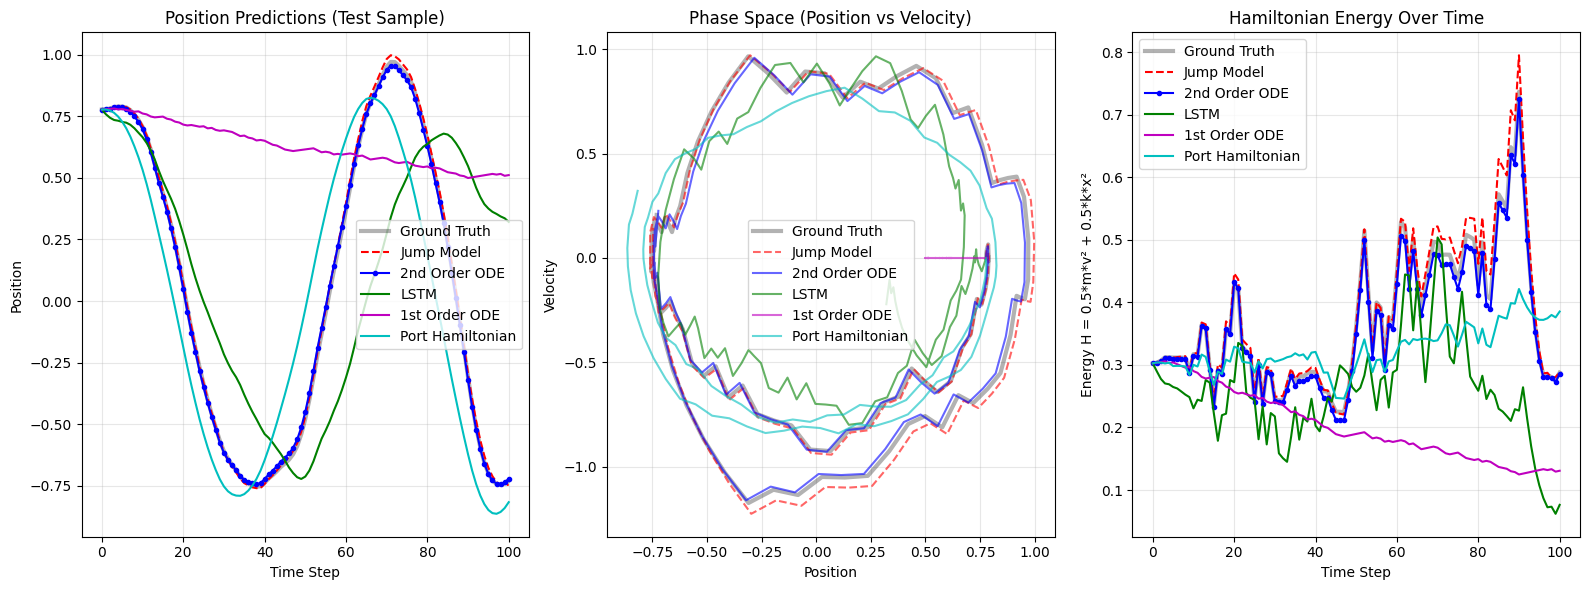

In [7]:
# Plot predictions for test sample 0
_ = plot_test_sample_predictions(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    shooting_model=None,  # Optional
    dataset=traj_dataset,
    sample_idx=0,
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
)

Simulating Unroll for 50 steps...


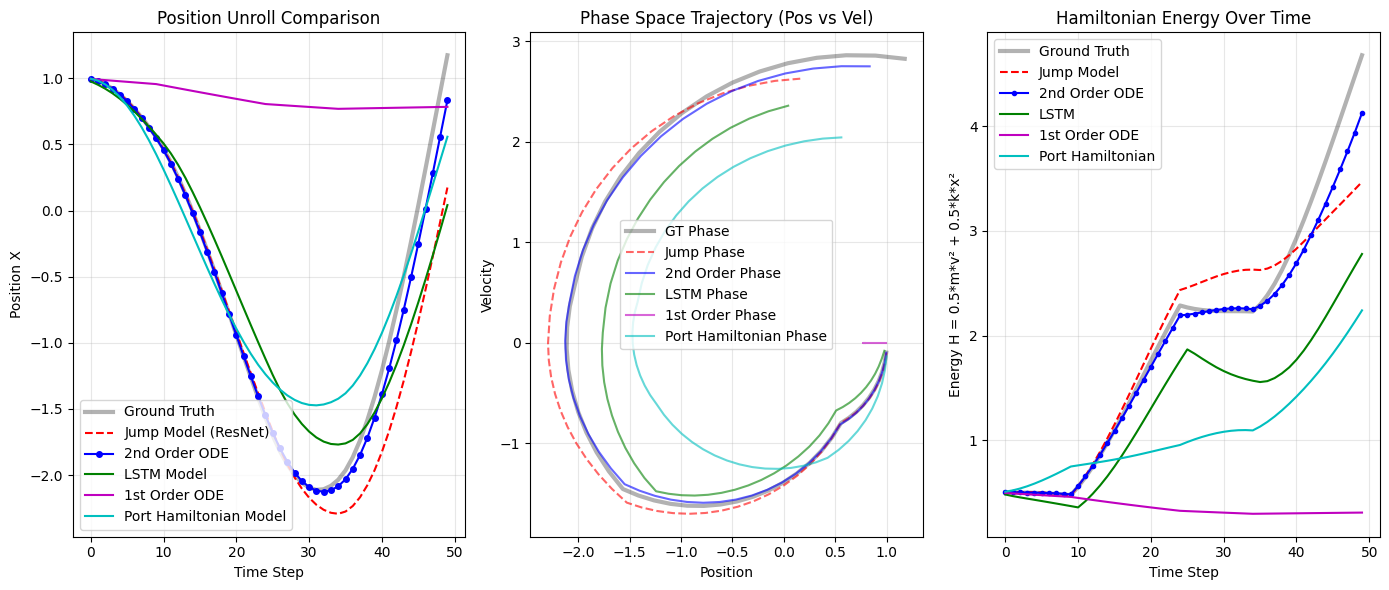

In [102]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
)

## Frame Rate Generalization

Dataset is generated at dt=0.1. Models trained at dt=0.1.


dt=0.2


Simulating Unroll for 50 steps...


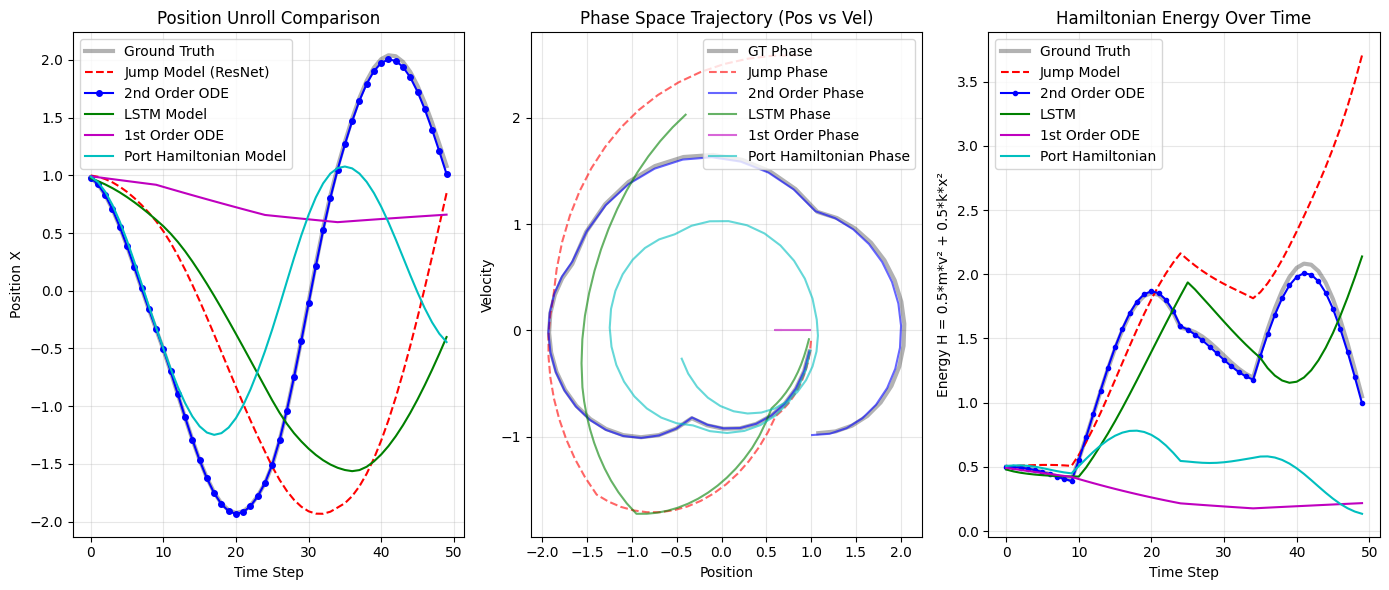

In [8]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
    c=0.1,
)

dt=0.5


Simulating Unroll for 50 steps...


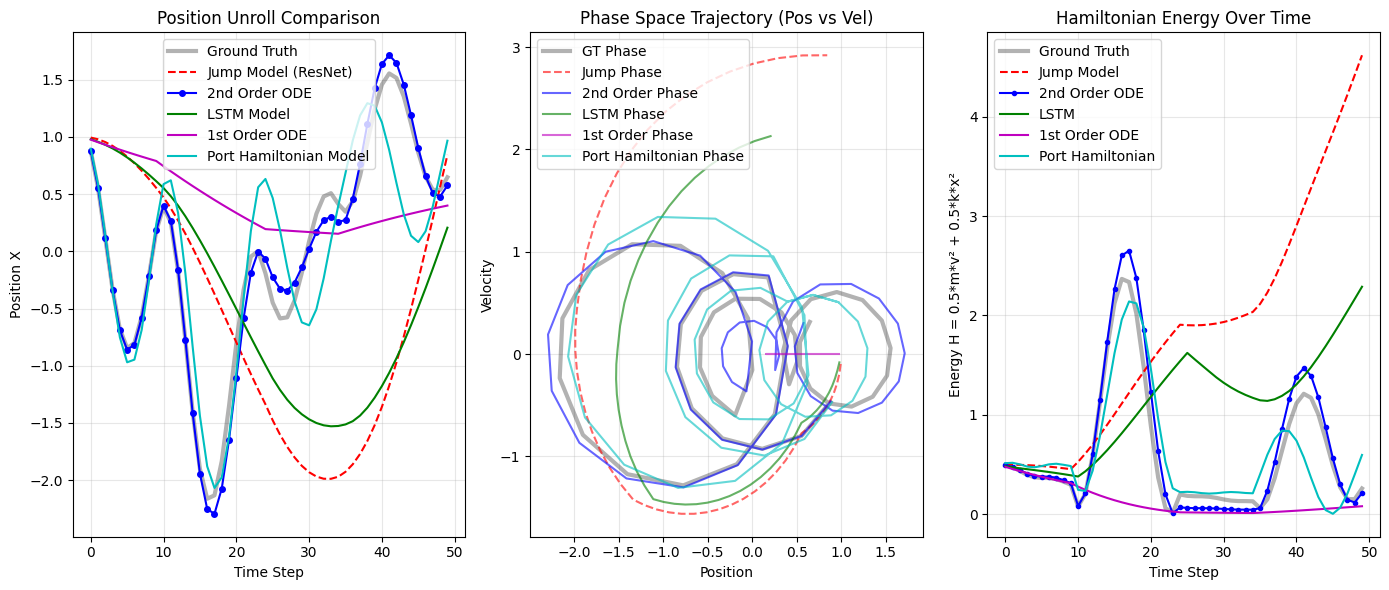

In [74]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.5,
    c=0.1,
)

dt=1


Simulating Unroll for 50 steps...


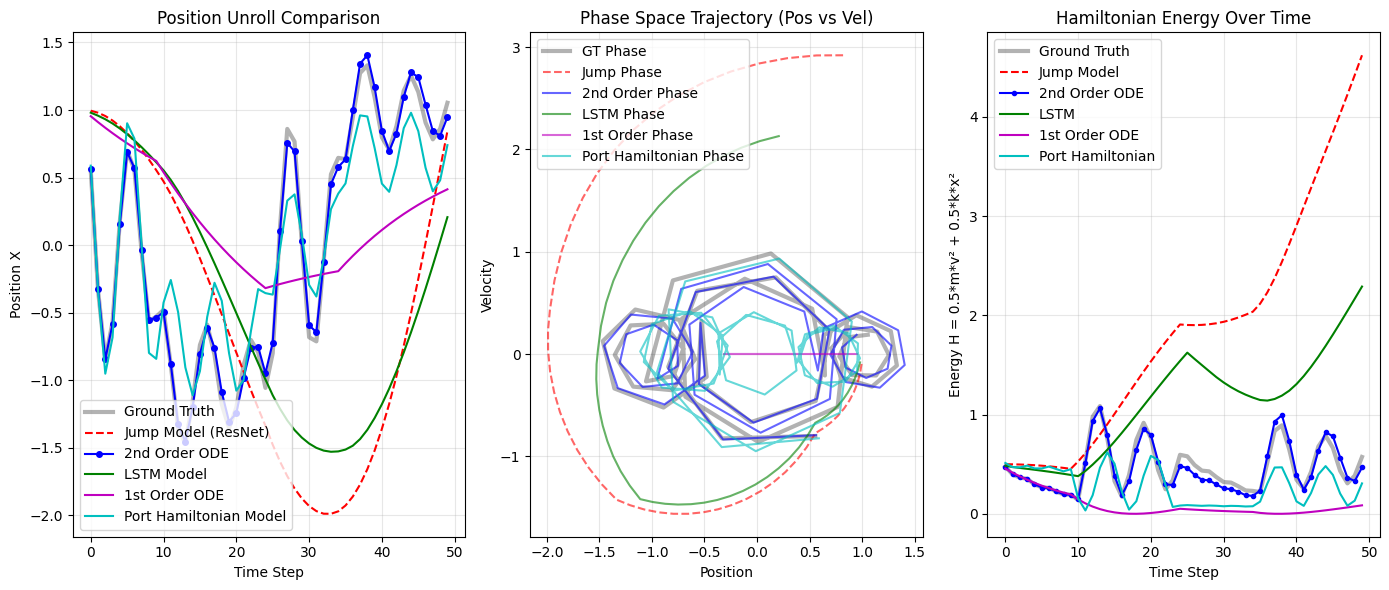

In [75]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=1,
    c=0.1,
)

dt=2


Simulating Unroll for 50 steps...


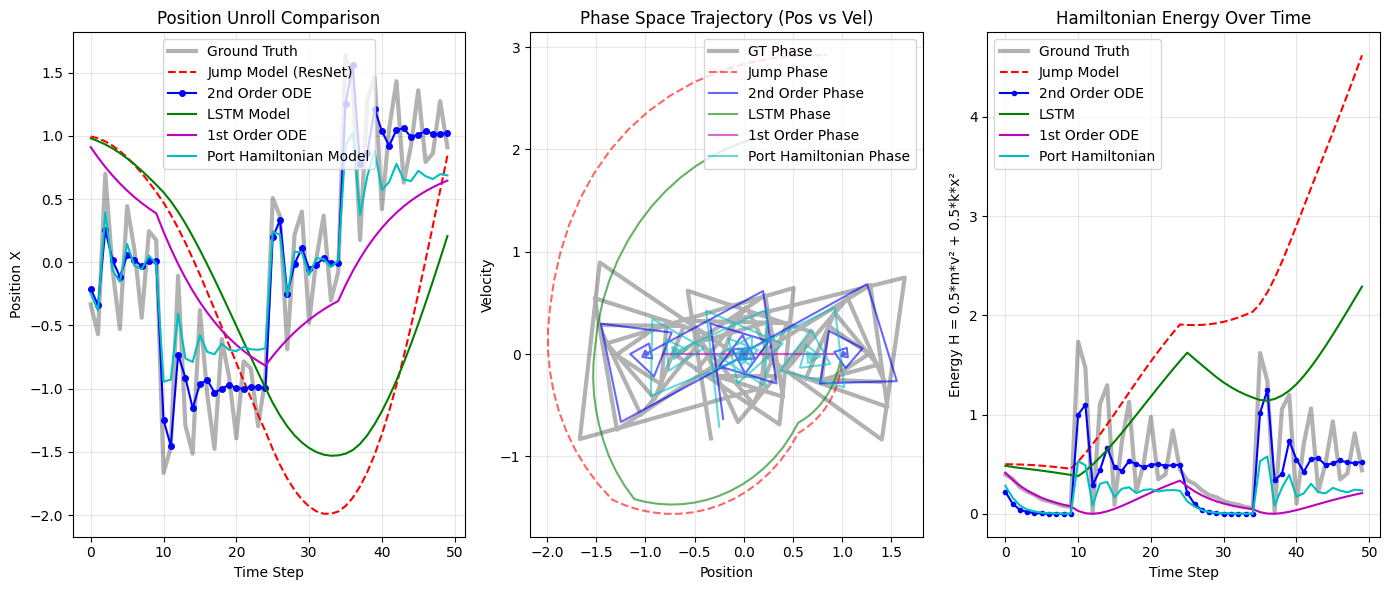

In [76]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=2,
    c=0.1,
)

Simulating Unroll for 50 steps...


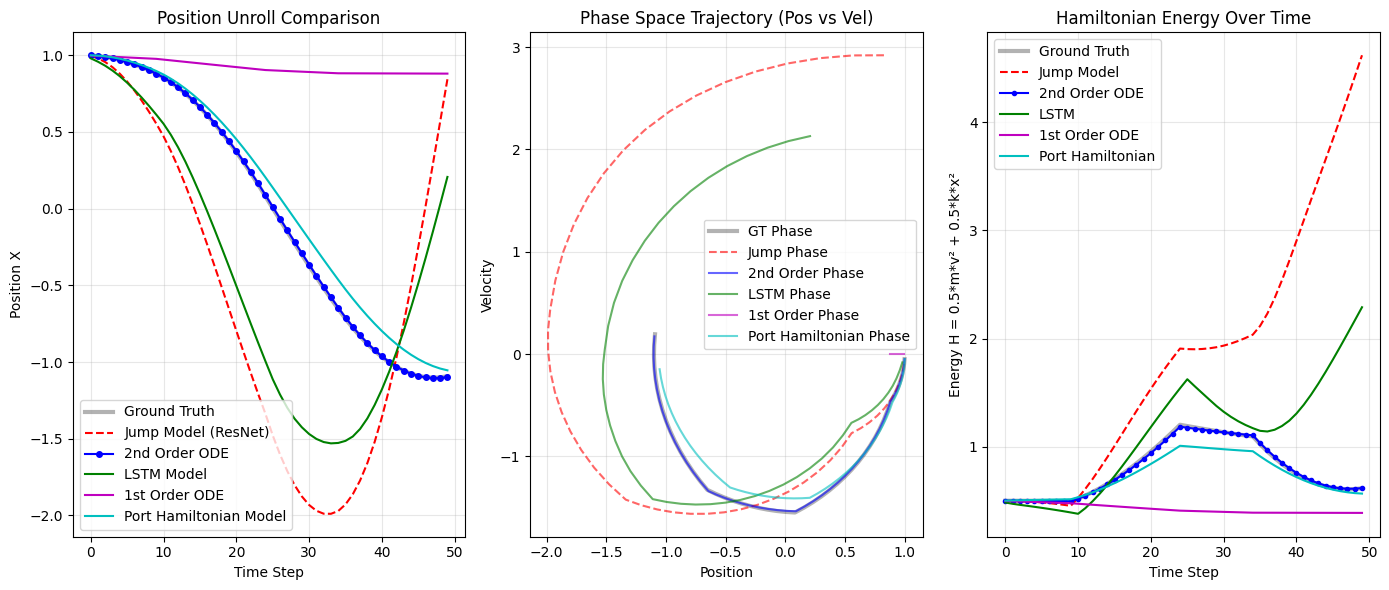

In [77]:
visualize_trajectory_unroll(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.05,
    c=0.1,
)

In [46]:
def compute_energy(states, m=1.0, k=1.0):
    """
    Compute Hamiltonian energy from state predictions.

    Args:
        states: [T, 2] array where states[:, 0] = position, states[:, 1] = velocity
        m: mass (default 1.0)
        k: spring constant (default 1.0)

    Returns:
        energies: [T] array of energy values
    """
    x = states[:, 0]
    v = states[:, 1]
    kinetic = 0.5 * m * v**2
    potential = 0.5 * k * x**2
    return kinetic + potential


def plot_test_sample_with_energy(
    jump_model,
    traj_model,
    lstm_model,
    first_order_model,
    port_hamiltonian_model,
    shooting_model=None,
    dataset=None,
    sample_idx=0,
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
    m=1.0,
    k=1.0,
):
    """
    Plot position, phase space, AND energy for all models on a test sample.
    """
    from torch.utils.data import DataLoader

    if dataset is None:
        raise ValueError("Dataset must be provided")

    # Get test sample
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    test_indices = perm[int(len_dataset * 0.8) :]
    test_sample = dataset[test_indices[sample_idx]]

    # Extract ground truth data
    gt_states = test_sample["states"]
    gt_targets = test_sample["targets"]
    actions = test_sample["actions"]

    gt_trajectory = torch.cat([gt_states[0:1], gt_targets], dim=0)

    # Initialize model states
    start_state = gt_states[0:1]

    curr_jump = start_state.clone()
    curr_traj = start_state.clone()
    curr_port_hamiltonian = start_state.clone()
    curr_first = start_state[:, 0:1].clone()

    # LSTM history buffer
    history_len = 4
    lstm_state_buffer = [start_state] * history_len
    lstm_action_buffer = [torch.tensor([1])] * history_len

    # Storage for predictions
    pred_jump = [start_state[0].numpy()]
    pred_traj = [start_state[0].numpy()]
    pred_lstm = [start_state[0].numpy()]
    pred_first = [np.array([start_state[0, 0].item(), 0.0])]
    pred_port_hamiltonian = [start_state[0].numpy()]
    pred_shooting = [start_state[0].numpy()] if shooting_model else None

    # Unroll predictions (same as before)
    T = len(actions)
    print(f"Unrolling predictions for {T} steps...")

    for t in range(T):
        act_idx = actions[t].item()
        act_tensor = torch.tensor([act_idx])

        with torch.no_grad():
            curr_jump = jump_model(curr_jump, act_tensor)
            pred_jump.append(curr_jump[0].numpy())

            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            pred_traj.append(curr_traj[0].numpy())

            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            pred_lstm.append(curr_lstm[0].numpy())

            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

            curr_first = first_order_model(curr_first, act_tensor, dt=dt)
            pred_first.append(np.array([curr_first[0, 0].item(), 0.0]))

            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            pred_port_hamiltonian.append(curr_port_hamiltonian[0].numpy())

            if shooting_model is not None:
                act_seq = torch.tensor([[act_idx]])
                curr_shooting_seq = shooting_model(
                    curr_port_hamiltonian, act_seq, dt
                )
                curr_shooting = curr_shooting_seq[:, -1, :]
                pred_shooting.append(curr_shooting[0].numpy())
                curr_port_hamiltonian = curr_shooting

    # Convert to numpy arrays
    pred_jump = np.array(pred_jump)
    pred_traj = np.array(pred_traj)
    pred_lstm = np.array(pred_lstm)
    pred_first = np.array(pred_first)
    pred_port_hamiltonian = np.array(pred_port_hamiltonian)
    gt_trajectory_np = gt_trajectory.numpy()

    # Compute energies
    energy_gt = compute_energy(gt_trajectory_np, m=m, k=k)
    energy_jump = compute_energy(pred_jump, m=m, k=k)
    energy_traj = compute_energy(pred_traj, m=m, k=k)
    energy_lstm = compute_energy(pred_lstm, m=m, k=k)
    energy_first = compute_energy(pred_first, m=m, k=k)
    energy_port_hamiltonian = compute_energy(pred_port_hamiltonian, m=m, k=k)

    if shooting_model is not None:
        pred_shooting = np.array(pred_shooting)
        energy_shooting = compute_energy(pred_shooting, m=m, k=k)

    time_steps = np.arange(len(gt_trajectory_np))

    # Create figure with 3 subplots: Position, Phase Space, Energy
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Position vs Time
    ax[0].plot(
        time_steps,
        gt_trajectory_np[:, 0],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0].plot(time_steps, pred_jump[:, 0], "r--", label="Jump Model")
    ax[0].plot(
        time_steps, pred_traj[:, 0], "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[0].plot(time_steps, pred_lstm[:, 0], "g-", label="LSTM")
    ax[0].plot(time_steps, pred_first[:, 0], "m-", label="1st Order ODE")
    ax[0].plot(
        time_steps, pred_port_hamiltonian[:, 0], "c-", label="Port Hamiltonian"
    )
    if shooting_model is not None:
        ax[0].plot(
            time_steps, pred_shooting[:, 0], "y-", label="Shooting Model"
        )

    ax[0].set_title("Position Predictions (Test Sample)")
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("Position")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot 2: Phase Space
    ax[1].plot(
        gt_trajectory_np[:, 0],
        gt_trajectory_np[:, 1],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[1].plot(
        pred_jump[:, 0], pred_jump[:, 1], "r--", alpha=0.6, label="Jump Model"
    )
    ax[1].plot(
        pred_traj[:, 0],
        pred_traj[:, 1],
        "b-",
        alpha=0.6,
        label="2nd Order ODE",
    )
    ax[1].plot(pred_lstm[:, 0], pred_lstm[:, 1], "g-", alpha=0.6, label="LSTM")
    ax[1].plot(
        pred_first[:, 0],
        pred_first[:, 1],
        "m-",
        alpha=0.6,
        label="1st Order ODE",
    )
    ax[1].plot(
        pred_port_hamiltonian[:, 0],
        pred_port_hamiltonian[:, 1],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian",
    )
    if shooting_model is not None:
        ax[1].plot(
            pred_shooting[:, 0],
            pred_shooting[:, 1],
            "y-",
            alpha=0.6,
            label="Shooting Model",
        )

    ax[1].set_title("Phase Space (Position vs Velocity)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot 3: Energy vs Time
    ax[2].plot(
        time_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[2].plot(time_steps, energy_jump, "r--", label="Jump Model")
    ax[2].plot(
        time_steps, energy_traj, "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[2].plot(time_steps, energy_lstm, "g-", label="LSTM")
    ax[2].plot(time_steps, energy_first, "m-", label="1st Order ODE")
    ax[2].plot(
        time_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )
    if shooting_model is not None:
        ax[2].plot(time_steps, energy_shooting, "y-", label="Shooting Model")

    ax[2].set_title("Hamiltonian Energy Over Time")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Energy H = 0.5*m*v² + 0.5*k*x²")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_trajectory_np,
        "jump": pred_jump,
        "traj": pred_traj,
        "lstm": pred_lstm,
        "first_order": pred_first,
        "port_hamiltonian": pred_port_hamiltonian,
        "shooting": pred_shooting if shooting_model else None,
        "energies": {
            "gt": energy_gt,
            "jump": energy_jump,
            "traj": energy_traj,
            "lstm": energy_lstm,
            "first_order": energy_first,
            "port_hamiltonian": energy_port_hamiltonian,
            "shooting": energy_shooting if shooting_model else None,
        },
    }

In [ ]:
_ = 

## Trajectory Matching Predict K Steps


In [36]:
import torch
import torch.nn as nn
from torchdiffeq import odeint


class TrajectoryShootingModel(nn.Module):
    def __init__(self, ode_func, dt=0.1):
        super().__init__()
        self.ode_func = ode_func
        self.dt = dt

    def forward(self, start_state, action_seq, dt=None):
        """
        Simulates the trajectory for K steps.

        Args:
            start_state: [Batch, 2] (Position, Velocity)
            action_seq:  [Batch, K] (Indices of actions)

        Returns:
            pred_states: [Batch, K, 2] (The sequence of future states)
        """
        batch_size, K = action_seq.shape
        curr_state = start_state
        pred_states = []
        dt = self.dt if dt is None else dt

        # We define a fixed time span for ONE step [0, dt]
        # The solver restarts at t=0 for every segment (autonomous dynamics assumption)
        t_span = torch.tensor([0.0, dt], device=start_state.device)

        for k in range(K):
            # 1. Get Action for this step
            # action_seq[:, k] is the action to be applied from t to t+1
            step_action = action_seq[:, k]

            # 2. Get Embedding (needed for the ODE func)
            act_emb = self.ode_func.act_emb(step_action)

            # 3. Define the Dynamics Closure
            # This binds the specific action 'act_emb' to the function
            def func(t, y):
                return self.ode_func(t, y, act_emb, step_action)

            # 4. Integrate for one step (dt)
            # Input: [B, 2] -> Output: [2, B, 2] (Start and End)
            # We take index [-1] to get the End state
            next_state = odeint(func, curr_state, t_span, method="rk4")[-1]

            # 5. Store and Recurse
            pred_states.append(next_state)
            curr_state = next_state  # Pass momentum to next step

        # Stack into [Batch, K, 2]
        return torch.stack(pred_states, dim=1)


# ==========================================
# TRAINING LOOP UPDATE
# ==========================================
def train_sequence_experiment(
    dataset, epochs=50, batch_size=32, lr=1e-3, K_shooting=5
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Models
    ode_core = SecondOrderODENet()
    shooting_model = TrajectoryShootingModel(ode_core, dt=0.1)

    optimizer = optim.Adam(shooting_model.parameters(), lr=1e-3)

    def train_step(batch):
        # Full sequence from dataset
        states_full = batch["states"]  # [B, 20, 2]
        actions_full = batch["actions"]  # [B, 20]
        targets_full = batch["targets"]  # [B, 20, 2]
        B, T, D = states_full.shape

        # Randomly crop a K-step segment for training
        # (Start anywhere between 0 and 15)
        t_start = np.random.randint(0, T - K_shooting)

        # Inputs
        start_z = states_full[:, t_start, :]  # [B, 2]
        act_seq = actions_full[:, t_start : t_start + K_shooting]  # [B, K]

        # Targets (The sequence of ground truth states)
        target_seq = targets_full[
            :, t_start : t_start + K_shooting, :
        ]  # [B, K, 2]

        # Forward (Simulate K steps)
        pred_seq = shooting_model(start_z, act_seq)

        # Loss: Average MSE over all K steps
        # This forces the model to be accurate at t+1, t+2... t+K
        loss = ((pred_seq - target_seq) ** 2).mean()

        # Optional: Add Velocity Regularization to prevent exploding gradients
        # loss += 0.01 * (pred_seq[..., 1]**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def test_step(batch):
        states_full = batch["states"]  # [B, 20, 2]
        actions_full = batch["actions"]  # [B, 20]
        targets_full = batch["targets"]  # [B, 20, 2]
        B, T, D = states_full.shape

        t_start = np.random.randint(0, T - K_shooting)

        # Inputs
        start_z = states_full[:, t_start, :]  # [B, 2]
        act_seq = actions_full[:, t_start : t_start + K_shooting]  # [B, K]

        # Targets (The sequence of ground truth states)
        target_seq = targets_full[
            :, t_start : t_start + K_shooting, :
        ]  # [B, K, 2]

        # Forward (Simulate K steps)
        pred_seq = shooting_model(start_z, act_seq)

        # Loss: Average MSE over all K steps
        # This forces the model to be accurate at t+1, t+2... t+K
        loss = ((pred_seq - target_seq) ** 2).mean()
        return loss.item()

    print("Training with Sequence Shooting (K=5)...")

    # We will train on subsequences of length K=5 for stability
    pbar = tqdm(range(1, epochs + 1), desc=f"Epoch {1} | Seq Loss: 0.0000")

    for epoch in pbar:
        total_loss = 0

        for batch in train_loader:
            loss = train_step(batch)
            total_loss += loss

        epoch_loss = total_loss / len(train_loader)
        pbar.set_description(f"Epoch {epoch} | Seq Loss: {epoch_loss:.4f}")

    # test
    test_loss = 0
    for batch in test_loader:
        loss = test_step(batch)
        test_loss += loss

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    return shooting_model

In [38]:
shooting_model = train_sequence_experiment(
    traj_dataset, epochs=100, batch_size=32, lr=1e-4, K_shooting=5
)

Training with Sequence Shooting (K=5)...


Epoch 100 | Seq Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 40.29it/s]

Test Loss: 0.0000


In [23]:
def visualize_shooting_unroll(
    jump_model,
    traj_model_1step,
    shooting_model_kstep,  # <--- Added K-step model
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.3,
    force_range=(-1, 1),  # Adjusted default to match physics class
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Warmup History
    state = torch.tensor([1.0, 0.0])

    # Initialize all models at the same start state
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj_1 = state.unsqueeze(0)
    curr_shoot_k = state.unsqueeze(0)  # <--- Added

    # 2. Define Action Sequence
    # Wait, Push Left, Wait, Push Right
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    gt_hist = []
    jump_hist = []
    traj_1_hist = []
    shoot_k_hist = []  # <--- Added

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, c, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step (Discrete Map)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Model Step (1-Step Trained)
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj_1 = traj_model_1step(curr_traj_1, act_tensor, dt=dt)
            traj_1_hist.append(curr_traj_1[0].numpy())

        # D. Shooting Model Step (K-Step Trained) <--- Added
        with torch.no_grad():
            # We treat it as a 1-step unroll here to test stability
            # Input expects [Batch, SeqLen], so we create [1, 1]
            act_seq = torch.tensor([[act_idx]])

            # Returns sequence of states [Batch, 1, 2]
            curr_shoot_seq = shooting_model_kstep(curr_shoot_k, act_seq)

            # Update current state (take the last/only step)
            curr_shoot_k = curr_shoot_seq[:, -1, :]
            shoot_k_hist.append(curr_shoot_k[0].numpy())

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_1_hist = np.array(traj_1_hist)
    shoot_k_hist = np.array(shoot_k_hist)

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # --- Plot Position ---
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=4, alpha=0.2, label="Ground Truth"
    )
    ax[0].plot(
        t_steps, jump_hist[:, 0], "r--", lw=1.5, label="Jump Model (ResNet)"
    )
    ax[0].plot(
        t_steps,
        traj_1_hist[:, 0],
        "b-.",
        alpha=0.8,
        label="ODE (Trained 1-Step)",
    )
    ax[0].plot(
        t_steps,
        shoot_k_hist[:, 0],
        "g-",  # Green Solid
        lw=2,
        alpha=0.9,
        label="ODE (Shooting K-Step)",
    )

    ax[0].set_title("Position Unroll Comparison")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # --- Plot Phase Space ---
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=4, alpha=0.2, label="GT Phase"
    )
    ax[1].plot(
        jump_hist[:, 0], jump_hist[:, 1], "r--", lw=1, alpha=0.5, label="Jump"
    )
    ax[1].plot(
        traj_1_hist[:, 0],
        traj_1_hist[:, 1],
        "b-.",
        lw=1,
        alpha=0.6,
        label="ODE 1-Step",
    )
    ax[1].plot(
        shoot_k_hist[:, 0],
        shoot_k_hist[:, 1],
        "g-",
        lw=2,
        alpha=0.8,
        label="ODE Shooting",
    )

    ax[1].set_title("Phase Space (Velocity vs Position)")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Simulating Unroll for 50 steps...


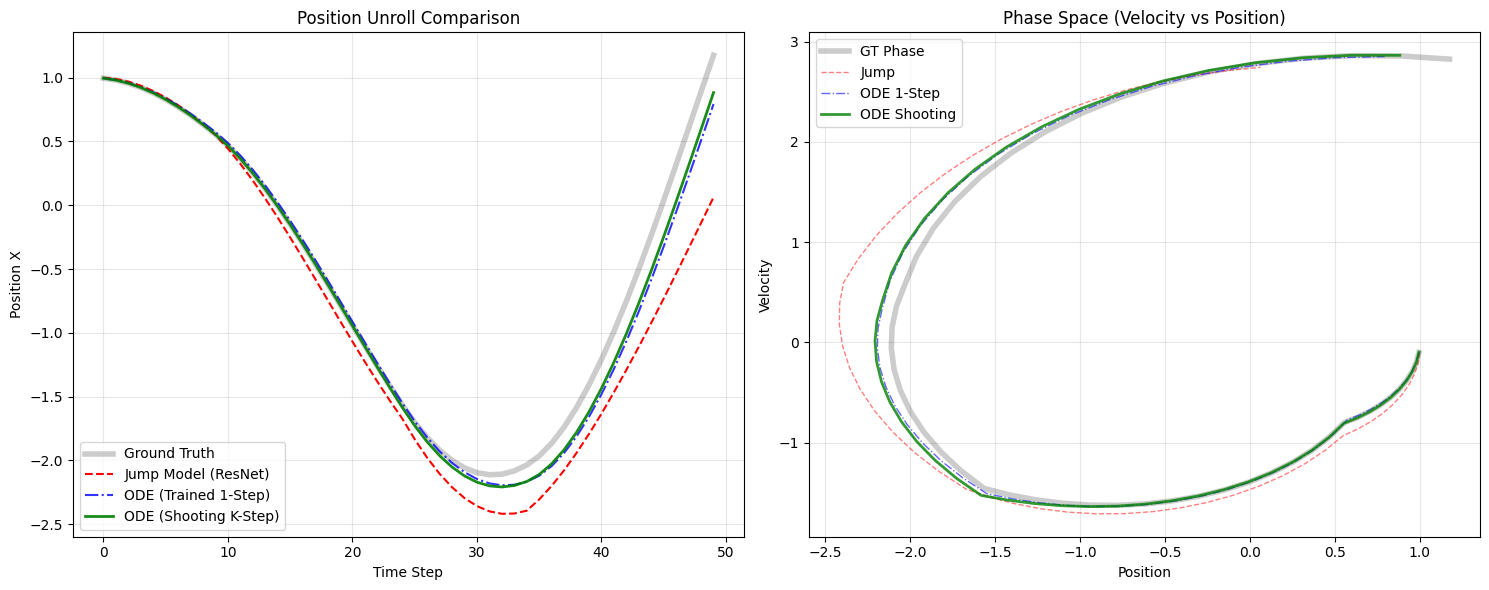

In [27]:
visualize_shooting_unroll(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
)

In [41]:
def visualize_shooting_k_analysis(
    jump_model,
    traj_model_1step,
    shooting_model_kstep,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    force_range=(-10, 10),
    K_horizon=5,  # The training horizon of the shooting model
    shoot_interval=5,  # How often to plot the lookahead
    show_traj_1_step=True,
):
    physics = ForcedOscillator(force_range=force_range)

    # 1. Setup & Warmup
    state = torch.tensor([1.0, 0.0])
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj_1 = state.unsqueeze(0)
    curr_shoot_auto = state.unsqueeze(0)

    # 2. Define Full Action Sequence
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    # Storage for continuous paths
    gt_hist = []
    jump_hist = []
    traj_1_hist = []
    shoot_auto_hist = []

    # Storage for "Shooting Bursts" (List of [K, 2] arrays)
    shooting_bursts = []
    burst_start_times = []

    print(f"Simulating Unroll for {len(actions)} steps...")

    # 3. Main Simulation Loop
    for t, act_idx in enumerate(actions):

        # --- A. Record History ---
        gt_hist.append(curr_gt.numpy())
        jump_hist.append(curr_jump[0].numpy())
        traj_1_hist.append(curr_traj_1[0].numpy())
        shoot_auto_hist.append(curr_shoot_auto[0].numpy())

        # --- B. The "Shooting" Lookahead ---
        # Every 'shoot_interval' steps, predict K steps into the future
        # starting from the GROUND TRUTH state (to check physics accuracy)
        if t % shoot_interval == 0 and t + K_horizon < len(actions):
            # 1. Get Action Sequence for next K steps
            act_seq_k = torch.tensor([actions[t : t + K_horizon]])  # [1, K]

            # 2. Get Current GT State
            curr_gt_tensor = curr_gt.unsqueeze(0)  # [1, 2]

            # 3. Predict K steps at once
            with torch.no_grad():
                # Output: [1, K, 2]
                burst_pred = shooting_model_kstep(
                    curr_gt_tensor, act_seq_k, dt
                )

            # 4. Store for plotting
            shooting_bursts.append(burst_pred[0].numpy())
            burst_start_times.append(t)

        # --- C. Step all models forward (Autoregressive) ---

        # Ground Truth
        curr_gt = physics.step(curr_gt, c, act_idx, dt)

        # Jump Model
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)

        # 1-Step ODE
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj_1 = traj_model_1step(curr_traj_1, act_tensor, dt=dt)

        # Shooting ODE (Used Autoregressively here for comparison)
        with torch.no_grad():
            act_seq_1 = torch.tensor([[act_idx]])
            curr_shoot_auto = shooting_model_kstep(
                curr_shoot_auto, act_seq_1, dt
            )[:, -1, :]

    # 4. Plotting
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_1_hist = np.array(traj_1_hist)
    shoot_auto_hist = np.array(shoot_auto_hist)
    t_steps = np.arange(len(actions))

    if show_traj_1_step:
        shoot_auto_hist = traj_1_hist

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # === PLOT 1: Position Time Series ===
    # Main Lines
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[0].plot(
        t_steps, jump_hist[:, 0], "r--", lw=1, alpha=0.5, label="Jump (ResNet)"
    )
    ax[0].plot(
        t_steps,
        shoot_auto_hist[:, 0],
        "g-",
        lw=1.5,
        alpha=0.6,
        label="Shooting (Autoregressive)",
    )

    # Plot Shooting Bursts
    # This loop plots the K-step predictions
    for i, burst in enumerate(shooting_bursts):
        start_t = burst_start_times[i]
        # Create time axis for this burst: [t+1, ..., t+K]
        burst_times = np.arange(start_t + 1, start_t + K_horizon + 1)

        # Plot segment
        label = "Shooting (K-Step Lookahead)" if i == 0 else None
        ax[0].plot(
            burst_times, burst[:, 0], "c-o", markersize=3, lw=2, label=label
        )

        # Draw a connector from start point
        ax[0].plot(
            [start_t, start_t + 1],
            [gt_hist[start_t, 0], burst[0, 0]],
            "c:",
            lw=1,
        )

    ax[0].set_title(f"Shooting Method Analysis (K={K_horizon})")
    ax[0].set_ylabel("Position X")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # === PLOT 2: Phase Space ===
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=3, alpha=0.2, label="GT Phase"
    )
    ax[1].plot(
        shoot_auto_hist[:, 0],
        shoot_auto_hist[:, 1],
        "g-",
        lw=1,
        alpha=0.4,
        label="Shooting (Auto)",
    )

    # Plot Bursts in Phase Space
    for i, burst in enumerate(shooting_bursts):
        start_t = burst_start_times[i]
        # Insert the starting GT point so the line connects to the path
        start_pt = gt_hist[start_t]

        # Concat [Start, Pred1, Pred2... PredK]
        full_burst = np.concatenate([start_pt.reshape(1, 2), burst], axis=0)

        ax[1].plot(full_burst[:, 0], full_burst[:, 1], "c-", lw=2, alpha=0.8)
        ax[1].plot(
            burst[-1, 0], burst[-1, 1], "c.", markersize=5
        )  # Mark end of prediction

    ax[1].set_title("Phase Space: K-Step Flow")
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Velocity")
    # Custom legend for phase space to avoid clutter
    from matplotlib.lines import Line2D

    custom_lines = [
        Line2D([0], [0], color="k", lw=3, alpha=0.2),
        Line2D([0], [0], color="g", lw=1),
        Line2D([0], [0], color="c", lw=2),
    ]
    ax[1].legend(
        custom_lines,
        ["Ground Truth", "Continuous Rollout", "K-Step Predictions"],
    )
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Simulating Unroll for 50 steps...


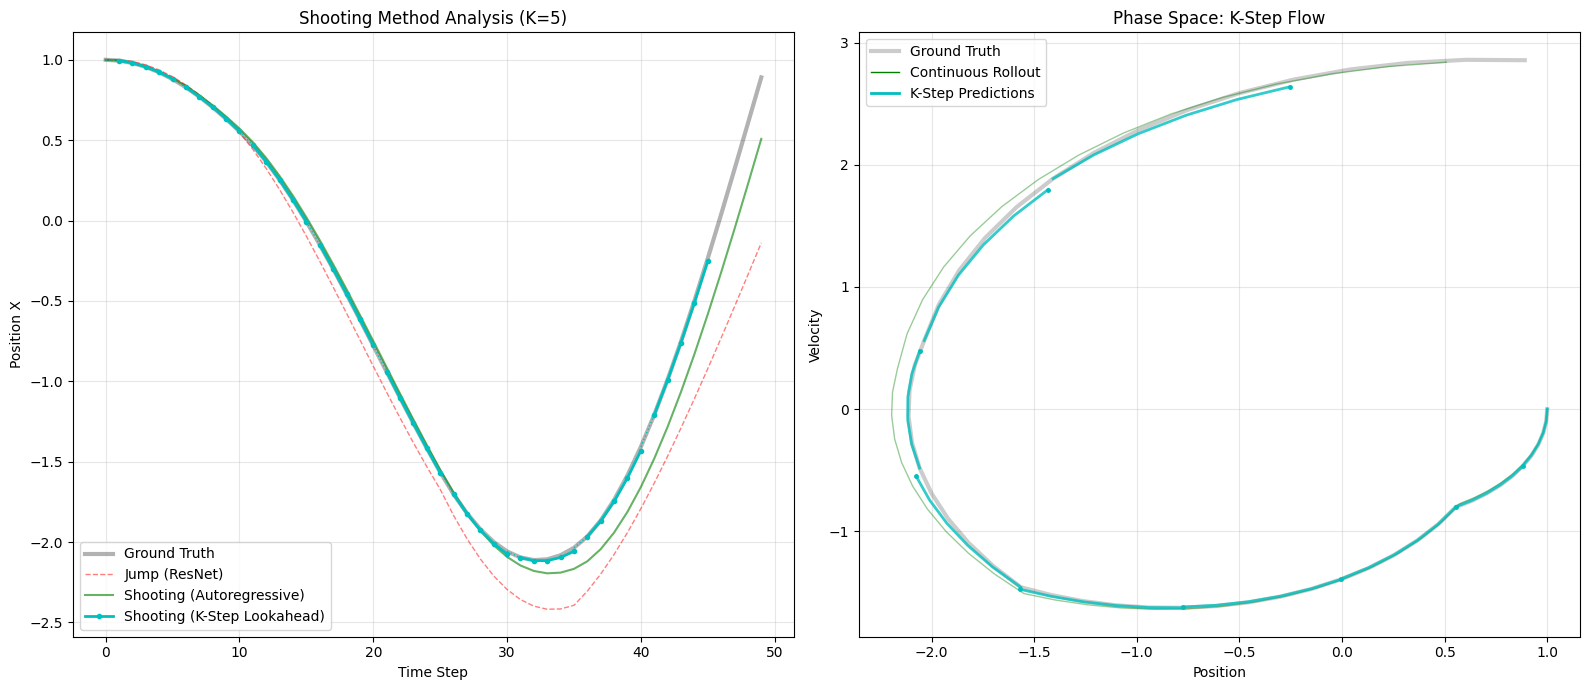

In [42]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
)

Simulating Unroll for 50 steps...


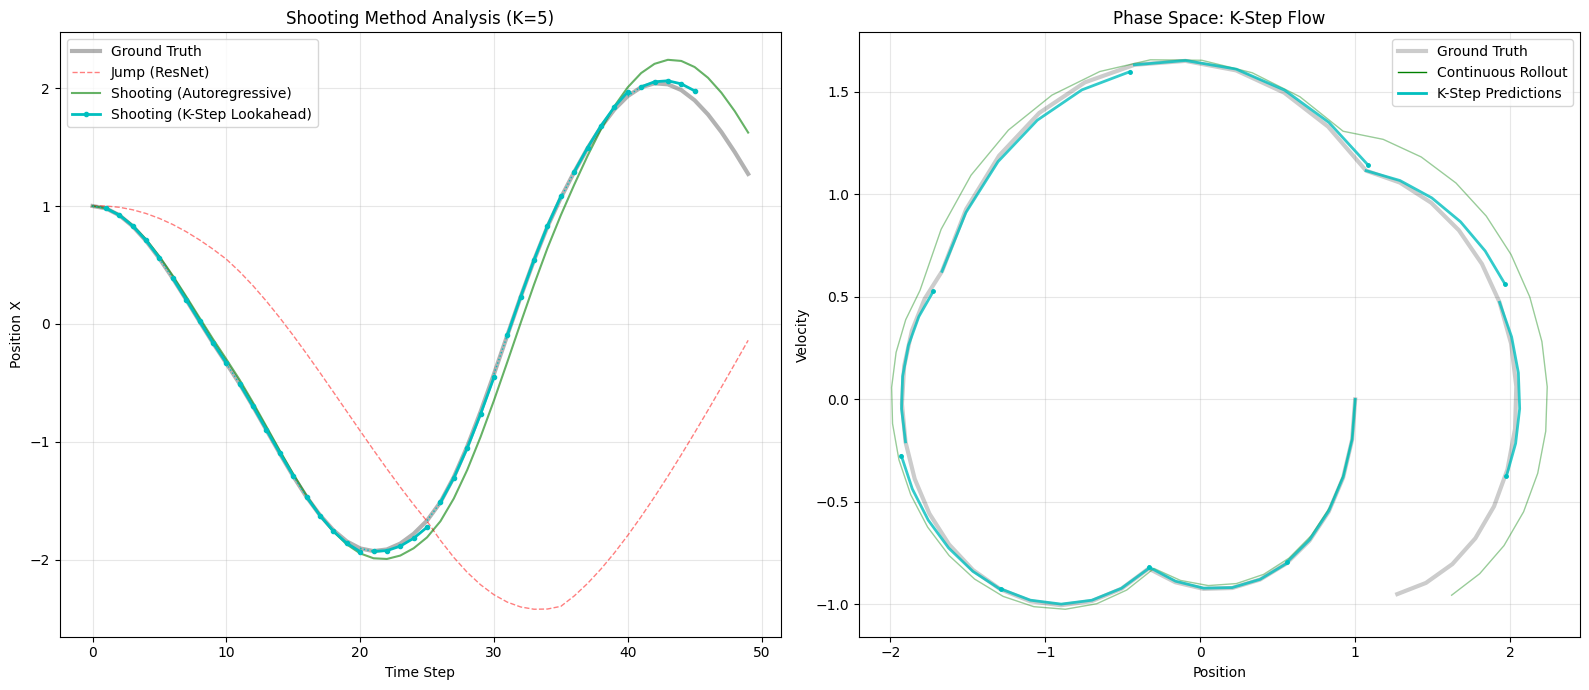

In [43]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
)

Simulating Unroll for 50 steps...


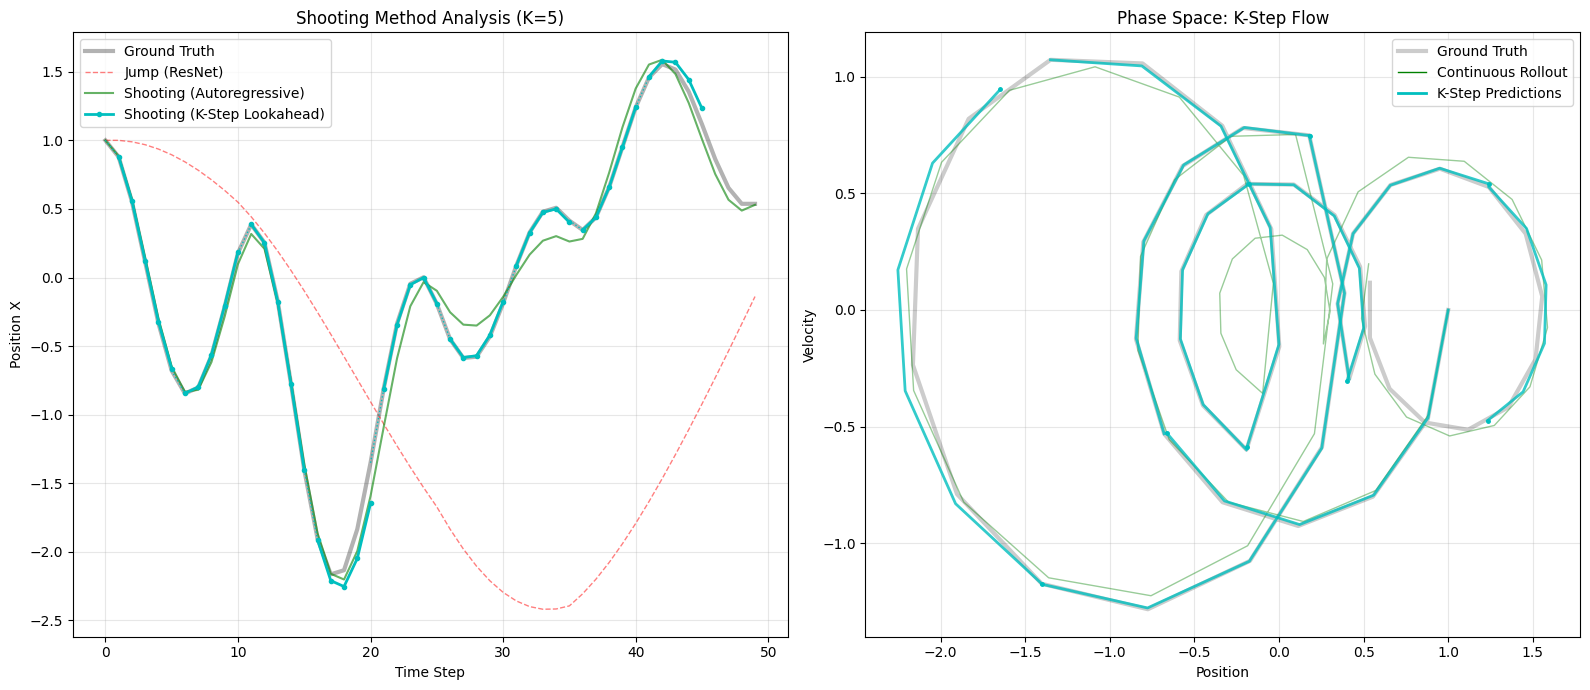

In [44]:
visualize_shooting_k_analysis(
    jump_model,
    traj_model,
    shooting_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.5,
)

# 2D Planar Oscillator: Energy Drift Analysis

Training models...
Running Long-Horizon Energy Drift Test...


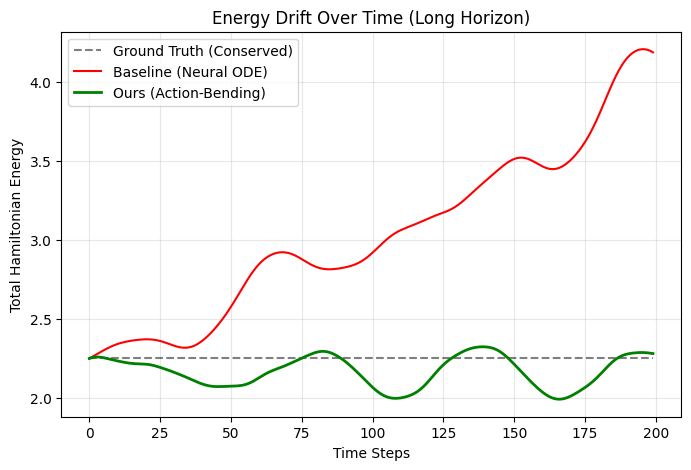

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


# ==========================================
# 1. 2D PHYSICS ENGINE (Conservative)
# ==========================================
class PlanarOscillator:
    def __init__(self, k=1.0):
        self.k = k  # Spring constant
        # Actions: [0: Coast, 1: Up, 2: Down, 3: Left, 4: Right]
        self.action_vecs = torch.tensor(
            [[0.0, 0.0], [0.0, 1.0], [0.0, -1.0], [-1.0, 0.0], [1.0, 0.0]]
        )

    def get_energy(self, state):
        """Hamiltonian = 0.5*v^2 + 0.5*k*x^2"""
        x = state[..., 0:2]
        v = state[..., 2:4]
        kinetic = 0.5 * (v**2).sum(dim=-1)
        potential = 0.5 * self.k * (x**2).sum(dim=-1)
        return kinetic + potential

    def step(self, state, action_idx, dt=0.1):
        """Ground Truth Dynamics"""
        u = self.action_vecs[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0:2], s[..., 2:4]
            dxdt = v
            # F_net = F_action - k*x (No damping for energy test)
            dvdt = u - self.k * x
            return torch.cat([dxdt, dvdt], dim=-1)

        return odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]


# ==========================================
# 2. DATASET
# ==========================================
class OscillatorDataset(Dataset):
    def __init__(self, n_seqs=100, seq_len=50, dt=0.1):
        self.data = []
        physics = PlanarOscillator()

        for _ in range(n_seqs):
            # Start at random position on the unit circle
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(1.0, 2.0)
            x_init = torch.tensor(
                [
                    r * np.cos(theta),
                    r * np.sin(theta),
                    -r * np.sin(theta),
                    r * np.cos(theta),
                ]
            )  # Orbit velocity

            states, actions = [x_init], []
            curr = x_init

            for _ in range(seq_len):
                # Randomly steer or coast
                a = np.random.randint(0, 5)
                curr = physics.step(curr, a, dt)
                states.append(curr)
                actions.append(a)

            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline: Unconstrained Neural ODE ---
class BaselineNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)
        self.net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 2),  # Outputs Acceleration directly
        )

    def forward(self, t, state, action_emb):
        x, v = state[..., 0:2], state[..., 2:4]
        # Simply predicts acceleration from state + action
        acc = self.net(torch.cat([x, v, action_emb], dim=-1))
        return torch.cat([v, acc], dim=-1)


# --- Ours: Symplectic Action-Bending ---
class ActionBendingNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)

        # 1. Learn Potential U(x) -> Scalar
        self.potential_net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 1)
        )

        # 2. Learn Action Force (Raw)
        self.control_net = nn.Sequential(
            nn.Linear(4 + 16, 64), nn.Tanh(), nn.Linear(64, 2)
        )

    def forward(self, t, state, action_emb):
        # Enable grad for Potential calculation
        with torch.enable_grad():
            x = state[..., 0:2].requires_grad_(True)
            v = state[..., 2:4]

            # A. Conservative Force: F = -Grad(U)
            # We predict Potential Energy U, then take derivative w.r.t x
            u_val = self.potential_net(x).sum()
            grad_u = torch.autograd.grad(u_val, x, create_graph=True)[0]
            f_env = -grad_u

            # B. Action Bending
            f_raw = self.control_net(torch.cat([x, v, action_emb], dim=-1))

            # Projection: F_bend = F_raw - (F_raw . v / |v|^2) * v
            v_sq = (v**2).sum(dim=-1, keepdim=True) + 1e-6
            proj = (f_raw * v).sum(dim=-1, keepdim=True) / v_sq
            f_bend = f_raw - (proj * v)

            # Total Acceleration
            acc = f_env + f_bend

        return torch.cat([v, acc], dim=-1)


# Wrapper for ODE Integration
class NeuralODEWrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, state, action_idx, dt=0.1):
        emb = self.func.act_emb(action_idx)

        def f(t, y):
            return self.func(t, y, emb)

        return odeint(f, state, torch.tensor([0.0, dt]), method="rk4")[-1]


# ==========================================
# 4. EXPERIMENT: ENERGY DRIFT
# ==========================================
def run_comparison():
    # Generate Data
    dataset = OscillatorDataset(n_seqs=50, seq_len=20)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Init Models
    baseline = NeuralODEWrapper(BaselineNode())
    ours = NeuralODEWrapper(ActionBendingNode())

    opt_b = optim.Adam(baseline.parameters(), lr=1e-3)
    opt_o = optim.Adam(ours.parameters(), lr=1e-3)

    # Training Loop (Brief)
    print("Training models...")
    for epoch in range(50):
        for batch in loader:
            s, a, t = batch["states"], batch["actions"], batch["targets"]

            # Flatten for 1-step training
            s_flat, a_flat, t_flat = s.view(-1, 4), a.view(-1), t.view(-1, 4)

            # Train Baseline
            pred_b = baseline(s_flat, a_flat)
            loss_b = ((pred_b - t_flat) ** 2).mean()
            opt_b.zero_grad()
            loss_b.backward()
            opt_b.step()

            # Train Ours
            pred_o = ours(s_flat, a_flat)
            loss_o = ((pred_o - t_flat) ** 2).mean()
            opt_o.zero_grad()
            loss_o.backward()
            opt_o.step()

    # --- THE CRITICAL TEST: Long Horizon Drift ---
    print("Running Long-Horizon Energy Drift Test...")
    physics = PlanarOscillator()

    # Initial State [x=1.5, y=0, vx=0, vy=1.5] (Circular Orbit ish)
    start = torch.tensor([[1.5, 0.0, 0.0, 1.5]])

    # Action Sequence: Coasting (Action 0) for 200 steps
    # We test "Coasting" because that's where drift is most obvious
    actions = torch.zeros(200).long()

    curr_b, curr_o = start.clone(), start.clone()
    energies_b, energies_o, energies_gt = [], [], []

    for a in actions:
        # Calculate Energy
        energies_gt.append(physics.get_energy(start).item())  # Constant
        energies_b.append(physics.get_energy(curr_b).item())
        energies_o.append(physics.get_energy(curr_o).item())

        # Step
        with torch.no_grad():
            curr_b = baseline(curr_b, a.unsqueeze(0))
            curr_o = ours(curr_o, a.unsqueeze(0))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(energies_gt, "k--", label="Ground Truth (Conserved)", alpha=0.5)
    plt.plot(energies_b, "r-", label="Baseline (Neural ODE)")
    plt.plot(energies_o, "g-", linewidth=2, label="Ours (Action-Bending)")
    plt.title("Energy Drift Over Time (Long Horizon)")
    plt.ylabel("Total Hamiltonian Energy")
    plt.xlabel("Time Steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("energy_drift.png", dpi=300)
    plt.show()


run_comparison()

Starting 5 experimental runs to generate error bounds...


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


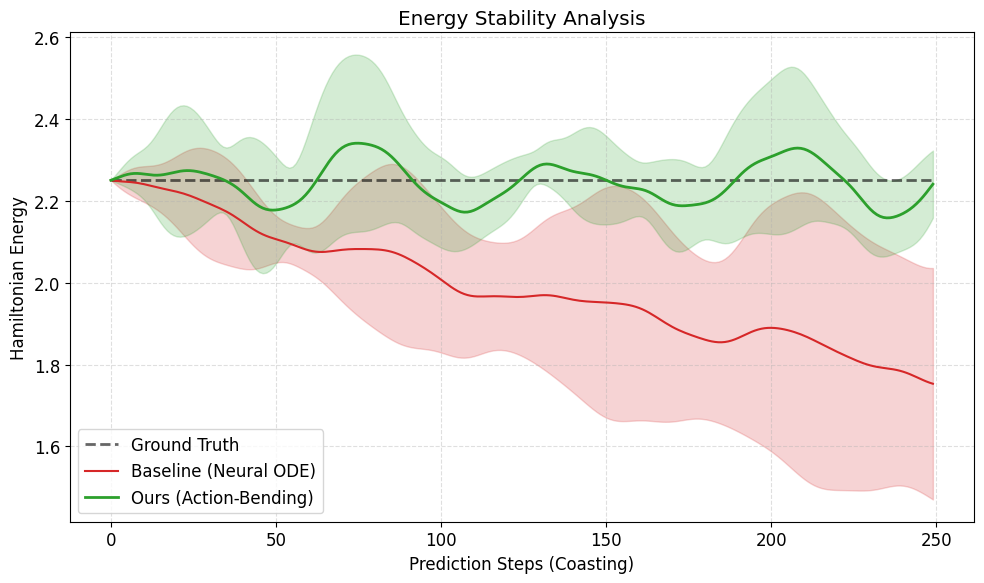

Plot saved as 'energy_stability_bounds.png'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm  # For progress bars


# ==========================================
# 1. 2D PHYSICS ENGINE (Conservative)
# ==========================================
class PlanarOscillator:
    def __init__(self, k=1.0):
        self.k = k  # Spring constant
        # Actions: [0: Coast, 1: Up, 2: Down, 3: Left, 4: Right]
        self.action_vecs = torch.tensor(
            [[0.0, 0.0], [0.0, 1.0], [0.0, -1.0], [-1.0, 0.0], [1.0, 0.0]]
        )

    def get_energy(self, state):
        """Hamiltonian = 0.5*v^2 + 0.5*k*x^2"""
        x = state[..., 0:2]
        v = state[..., 2:4]
        kinetic = 0.5 * (v**2).sum(dim=-1)
        potential = 0.5 * self.k * (x**2).sum(dim=-1)
        return kinetic + potential

    def step(self, state, action_idx, dt=0.1):
        """Ground Truth Dynamics"""
        u = self.action_vecs[action_idx]

        def dynamics(t, s):
            x, v = s[..., 0:2], s[..., 2:4]
            dxdt = v
            # F_net = F_action - k*x (No damping for energy test)
            dvdt = u - self.k * x
            return torch.cat([dxdt, dvdt], dim=-1)

        return odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]


# ==========================================
# 2. DATASET
# ==========================================
class OscillatorDataset(Dataset):
    def __init__(self, n_seqs=100, seq_len=20, dt=0.1):
        self.data = []
        physics = PlanarOscillator()

        for _ in range(n_seqs):
            # Start at random position on the unit circle
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(1.0, 2.0)
            x_init = torch.tensor(
                [
                    r * np.cos(theta),
                    r * np.sin(theta),
                    -r * np.sin(theta),
                    r * np.cos(theta),
                ]
            )  # Orbit velocity

            states, actions = [x_init], []
            curr = x_init

            for _ in range(seq_len):
                # Randomly steer or coast
                a = np.random.randint(0, 5)
                curr = physics.step(curr, a, dt)
                states.append(curr)
                actions.append(a)

            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS
# ==========================================


# --- Baseline: Unconstrained Neural ODE ---
class BaselineNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)
        self.net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),  # Outputs Acceleration directly
        )

    def forward(self, t, state, action_emb):
        x, v = state[..., 0:2], state[..., 2:4]
        # Simply predicts acceleration from state + action
        acc = self.net(torch.cat([x, v, action_emb], dim=-1))
        return torch.cat([v, acc], dim=-1)


# --- Ours: Symplectic Action-Bending ---
class ActionBendingNode(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_emb = nn.Embedding(5, 16)

        # 1. Learn Potential U(x) -> Scalar
        self.potential_net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

        # 2. Learn Action Force (Raw)
        self.control_net = nn.Sequential(
            nn.Linear(4 + 16, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
        )

    def forward(self, t, state, action_emb):
        # Enable grad for Potential calculation
        with torch.enable_grad():
            x = state[..., 0:2].requires_grad_(True)
            v = state[..., 2:4]

            # A. Conservative Force: F = -Grad(U)
            # We predict Potential Energy U, then take derivative w.r.t x
            u_val = self.potential_net(x).sum()
            grad_u = torch.autograd.grad(u_val, x, create_graph=True)[0]
            f_env = -grad_u

            # B. Action Bending
            f_raw = self.control_net(torch.cat([x, v, action_emb], dim=-1))

            # Projection: F_bend = F_raw - (F_raw . v / |v|^2) * v
            # Add epsilon to prevent div by zero
            v_sq = (v**2).sum(dim=-1, keepdim=True) + 1e-6
            proj = (f_raw * v).sum(dim=-1, keepdim=True) / v_sq
            f_bend = f_raw - (proj * v)

            # Total Acceleration
            acc = f_env + f_bend

        return torch.cat([v, acc], dim=-1)


# Wrapper for ODE Integration
class NeuralODEWrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, state, action_idx, dt=0.1):
        emb = self.func.act_emb(action_idx)

        def f(t, y):
            return self.func(t, y, emb)

        return odeint(f, state, torch.tensor([0.0, dt]), method="rk4")[-1]


# ==========================================
# 4. EXPERIMENT LOOP: MULTI-SEED
# ==========================================
def train_and_evaluate_single_run(run_id, steps=200):
    """
    Trains one instance of both models and returns their energy trajectories.
    """
    # 1. Setup Data
    dataset = OscillatorDataset(n_seqs=50, seq_len=20)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 2. Init Models
    baseline = NeuralODEWrapper(BaselineNode())
    ours = NeuralODEWrapper(ActionBendingNode())

    opt_b = optim.Adam(baseline.parameters(), lr=2e-3)
    opt_o = optim.Adam(ours.parameters(), lr=2e-3)

    # 3. Train
    epochs = 40
    # Silent training to avoid clutter
    for _ in range(epochs):
        for batch in loader:
            s, a, t = batch["states"], batch["actions"], batch["targets"]
            s_flat, a_flat, t_flat = s.view(-1, 4), a.view(-1), t.view(-1, 4)

            # Baseline Update
            pred_b = baseline(s_flat, a_flat)
            loss_b = ((pred_b - t_flat) ** 2).mean()
            opt_b.zero_grad()
            loss_b.backward()
            opt_b.step()

            # Ours Update
            pred_o = ours(s_flat, a_flat)
            loss_o = ((pred_o - t_flat) ** 2).mean()
            # Optional: Add small regularization to potential to keep it centered
            opt_o.zero_grad()
            loss_o.backward()
            opt_o.step()

    # 4. Long Horizon Test
    physics = PlanarOscillator()

    # Standard start state for all runs to compare drift
    start = torch.tensor([[1.5, 0.0, 0.0, 1.5]])
    actions = torch.zeros(steps).long()  # Coasting

    curr_b, curr_o = start.clone(), start.clone()
    e_b, e_o, e_gt = [], [], []

    # Initial Energy
    h0 = physics.get_energy(start).item()

    with torch.no_grad():
        for i, a in enumerate(actions):
            # Store normalized energy (H / H0)
            e_gt.append(physics.get_energy(start).item())
            e_b.append(physics.get_energy(curr_b).item())
            e_o.append(physics.get_energy(curr_o).item())

            # Step
            a_in = a.unsqueeze(0)
            curr_b = baseline(curr_b, a_in)
            curr_o = ours(curr_o, a_in)

    return e_b, e_o, e_gt


def run_multi_seed_experiment(num_runs=5, steps=200):
    print(f"Starting {num_runs} experimental runs to generate error bounds...")

    results_baseline = []
    results_ours = []
    ground_truth = None

    for i in tqdm(range(num_runs)):
        e_b, e_o, e_gt = train_and_evaluate_single_run(i, steps=steps)
        results_baseline.append(e_b)
        results_ours.append(e_o)
        ground_truth = e_gt  # Ground truth is constant/same

    # Convert to numpy for stats
    res_b = np.array(results_baseline)  # [Runs, Steps]
    res_o = np.array(results_ours)

    # Calculate Stats
    mu_b, std_b = res_b.mean(axis=0), res_b.std(axis=0)
    mu_o, std_o = res_o.mean(axis=0), res_o.std(axis=0)

    # Plotting
    plot_results(mu_b, std_b, mu_o, std_o, ground_truth, steps)

    return mu_b, std_b, mu_o, std_o, ground_truth, steps


def plot_results(mu_b, std_b, mu_o, std_o, gt, steps):
    x = np.arange(steps)

    plt.figure(figsize=(10, 6))
    plt.rcParams.update({"font.size": 12})

    # 1. Ground Truth
    plt.plot(x, gt, "k--", linewidth=2, label="Ground Truth", alpha=0.6)

    # 2. Baseline
    plt.plot(x, mu_b, color="tab:red", label="Baseline (Neural ODE)")
    plt.fill_between(x, mu_b - std_b, mu_b + std_b, color="tab:red", alpha=0.2)

    # 3. Ours
    plt.plot(
        x, mu_o, color="tab:green", linewidth=2, label="Ours (Action-Bending)"
    )
    plt.fill_between(
        x, mu_o - std_o, mu_o + std_o, color="tab:green", alpha=0.2
    )

    plt.title(f"Energy Stability Analysis")
    plt.ylabel("Hamiltonian Energy")
    plt.xlabel("Prediction Steps (Coasting)")
    plt.legend(loc="lower left")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    # Save or Show
    plt.savefig("energy_stability_bounds.png", dpi=300)
    plt.show()
    print("Plot saved as 'energy_stability_bounds.png'")


mu, std, mu_o, std_o, ground_truth, steps = run_multi_seed_experiment(
    num_runs=5, steps=250
)

In [ ]:
plot_results(mu, std, mu_o, std_o, ground_truth, steps)

# 

# B. The "Torque-Controlled" Pendulum
This is the standard "Pendulum-v1" environment found in reinforcement learning libraries (like OpenAI Gym).
Physics Modification:
Original: $\ddot{\theta} = -\frac{g}{L} \sin(\theta)$
Modified: $\ddot{\theta} = -\frac{g}{L} \sin(\theta) + \frac{u(t)}{mL^2}$
Action Space: Continuous scalar $u$ representing torque at the pivot.
Why use it: It tests non-linear potential energy. The model must learn that "Action $u$" adds energy to swing higher.
Test Case: The "Swing-up" task. Start at the bottom (low energy) and apply actions to pump energy into the system until it reaches the top (high energy).

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm


# ==========================================
# 1. FORCED PENDULUM PHYSICS ENGINE
# ==========================================
class ForcedPendulum:
    def __init__(self, m=1.0, L=1.0, g=9.81, torque_range=(-2, 2)):
        self.m, self.L, self.g = m, L, g
        self.torque_range = torque_range
        # Map Action Index -> Torque Value
        self.torque_map = {
            0: torque_range[0],  # Negative torque (push left)
            1: 0.0,  # No torque (coast)
            2: torque_range[1],  # Positive torque (push right)
        }

    def step(self, state, c, action_idx, dt=0.1):
        """
        Precise integration of the ground truth physics
        state: [theta, omega] where theta is angle, omega is angular velocity
        """
        u_val = self.torque_map[action_idx]

        def dynamics(t, s):
            theta, omega = s[..., 0], s[..., 1]
            dtheta_dt = omega
            # domega_dt = -(g/L)*sin(theta) - c*omega + u/(m*L^2)
            domega_dt = (
                -(self.g / self.L) * torch.sin(theta)
                - c * omega
                + u_val / (self.m * self.L**2)
            )
            return torch.stack([dtheta_dt, domega_dt], dim=-1)

        # Integrate exactly one step
        next_state = odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]
        return next_state

    def get_energy(self, state):
        """
        Compute Hamiltonian energy: E = 0.5*m*L^2*omega^2 + m*g*L*(1 - cos(theta))
        """
        theta, omega = state[..., 0], state[..., 1]
        kinetic = 0.5 * self.m * self.L**2 * omega**2
        potential = self.m * self.g * self.L * (1 - torch.cos(theta))
        return kinetic + potential


# ==========================================
# 2. PENDULUM DATASET (Sequence Generation)
# ==========================================
class PendulumSequenceDataset(Dataset):
    def __init__(
        self,
        n_seqs=200,
        seq_len=20,
        dt=0.1,
        m=1.0,
        L=1.0,
        g=9.81,
        torque_range=(-2, 2),
        c_range=(0.05, 0.5),
    ):
        self.data = []
        physics = ForcedPendulum(m=m, L=L, g=g, torque_range=torque_range)

        print(f"Generating {n_seqs} pendulum sequences of length {seq_len}...")

        for _ in range(n_seqs):
            # Randomize damping per sequence to force model to generalize
            c = np.random.uniform(c_range[0], c_range[1])
            # Start at random angle and velocity
            theta_init = np.random.uniform(-np.pi, np.pi)
            omega_init = np.random.uniform(-2.0, 2.0)
            state = torch.tensor([theta_init, omega_init])

            states = [state]
            actions = []

            # Generate Sequence
            for _ in range(seq_len):
                a = np.random.randint(0, 3)
                state = physics.step(state, c, a, dt)
                states.append(state)
                actions.append(a)

            # Store: (States[0:T], Actions[0:T], States[1:T+1])
            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),  # Inputs
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),  # Next steps
                    "c": c,
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. MODELS (Reuse from harmonic oscillator)
# ==========================================
# Models are already defined above, we'll reuse:
# - JumpModel
# - LSTMModel
# - SecondOrderODENet
# - PortHamiltonianModel


# ==========================================
# 4. PENDULUM TRAINING LOOP
# ==========================================
def train_pendulum_experiment(
    dataset, epochs=40, batch_size=32, lr=1e-3, verbose=False
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Models
    jump_model = JumpModel()
    lstm_model = LSTMModel()

    ode_core = SecondOrderODENet()
    traj_model = TrajectoryMatchingModel(ode_core)

    # Port Hamiltonian model
    port_hamiltonian_ode = PortHamiltonianModel()
    port_hamiltonian_model = TrajectoryMatchingModel(port_hamiltonian_ode)

    opt_jump = optim.Adam(jump_model.parameters(), lr=lr)
    opt_traj = optim.Adam(traj_model.parameters(), lr=lr)
    opt_lstm = optim.Adam(lstm_model.parameters(), lr=lr)
    opt_port_hamiltonian = optim.Adam(
        port_hamiltonian_model.parameters(), lr=lr
    )

    def train_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        # --- 1. Train Jump Model (One-Step MSE) ---
        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        opt_jump.zero_grad()
        loss_j.backward()
        opt_jump.step()

        opt_lstm.zero_grad()
        loss_lstm.backward()
        opt_lstm.step()

        # --- 2. Train Trajectory Models (Sequential Shooting) ---
        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        opt_traj.zero_grad()
        loss_t.backward()
        opt_traj.step()

        # --- 3. Train Port Hamiltonian Model ---
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        opt_port_hamiltonian.zero_grad()
        loss_port_hamiltonian.backward()
        opt_port_hamiltonian.step()

        return loss_j, loss_t, loss_lstm, loss_port_hamiltonian

    @torch.no_grad()
    def test_step(batch):
        states = batch["states"]  # [B, T, 2]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 2]

        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        # Port Hamiltonian model
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        return loss_j, loss_t, loss_lstm, loss_port_hamiltonian

    print("Training Pendulum Models...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {1} | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | PHNN: 0.0000",
    )
    for epoch in range(1, epochs + 1):
        total_j, total_t, total_lstm, total_port_hamiltonian = (
            0,
            0,
            0,
            0,
        )

        for batch in train_loader:
            loss_j, loss_t, loss_lstm, loss_port_hamiltonian = train_step(
                batch
            )
            total_j += loss_j.item()
            total_t += loss_t.item()
            total_lstm += loss_lstm.item()
            total_port_hamiltonian += loss_port_hamiltonian.item()

        epoch_loss_j = total_j / len(train_loader)
        epoch_loss_t = total_t / len(train_loader)
        epoch_loss_lstm = total_lstm / len(train_loader)
        epoch_loss_port_hamiltonian = total_port_hamiltonian / len(
            train_loader
        )
        pbar.set_description(
            f"Epoch {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | PHNN: {epoch_loss_port_hamiltonian:.4f}"
        )
        if verbose:
            print(
                f"Ep {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | PHNN: {epoch_loss_port_hamiltonian:.4f}",
                flush=True,
            )

    # test set
    print("Testing Pendulum Models...")
    total_j, total_t, total_lstm, total_port_hamiltonian = (
        0,
        0,
        0,
        0,
    )
    for batch in test_loader:
        loss_j, loss_t, loss_lstm, loss_port_hamiltonian = test_step(batch)
        total_j += loss_j.item()
        total_t += loss_t.item()
        total_lstm += loss_lstm.item()
        total_port_hamiltonian += loss_port_hamiltonian.item()

    test_loss_j = total_j / len(test_loader)
    test_loss_t = total_t / len(test_loader)
    test_loss_lstm = total_lstm / len(test_loader)
    test_loss_port_hamiltonian = total_port_hamiltonian / len(test_loader)
    print(
        f"Test | Jump: {test_loss_j:.4f} | Traj: {test_loss_t:.4f} | LSTM: {test_loss_lstm:.4f} | PHNN: {test_loss_port_hamiltonian:.4f}"
    )

    return (
        jump_model,
        traj_model,
        lstm_model,
        port_hamiltonian_model,
    )


# ==========================================
# 5. PENDULUM ENERGY COMPUTATION
# ==========================================
def compute_pendulum_energy(states, m=1.0, L=1.0, g=9.81):
    """
    Compute Hamiltonian energy from state predictions.

    Args:
        states: [T, 2] array where states[:, 0] = theta (angle), states[:, 1] = omega (angular velocity)
        m: mass (default 1.0)
        L: length (default 1.0)
        g: gravity (default 9.81)

    Returns:
        energies: [T] array of energy values
    """
    theta = states[:, 0]
    omega = states[:, 1]
    kinetic = 0.5 * m * L**2 * omega**2
    potential = m * g * L * (1 - np.cos(theta))
    return kinetic + potential


# ==========================================
# 6. PENDULUM VISUALIZATION (UNROLL)
# ==========================================
def visualize_pendulum_unroll(
    jump_model,
    traj_model,
    lstm_model,
    port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    torque_range=(-2, 2),
    history_len=4,
    m=1.0,
    L=1.0,
    g=9.81,
):
    physics = ForcedPendulum(m=m, L=L, g=g, torque_range=torque_range)

    # 1. Warmup History - start at bottom (theta=0, omega=0)
    state = torch.tensor([0.0, 0.0])
    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj = state.unsqueeze(0)
    curr_port_hamiltonian = state.unsqueeze(0)

    # Initialize LSTM history buffer
    lstm_state_buffer = [state.unsqueeze(0)] * history_len
    lstm_action_buffer = [torch.tensor([1])] * history_len

    # 2. Define Action Sequence
    actions = (
        [1] * treatment[1]
        + [0] * treatment[0]
        + [1] * treatment[1]
        + [2] * treatment[2]
    )

    (
        gt_hist,
        jump_hist,
        traj_hist,
        lstm_hist,
        port_hamiltonian_hist,
    ) = ([], [], [], [], [])

    print(f"Simulating Pendulum Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, c, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Matching Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            traj_hist.append(curr_traj[0].numpy())

        # D. LSTM Step - Use history buffer
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            lstm_hist.append(curr_lstm[0].numpy())

            # Update history buffer
            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

        # E. Port Hamiltonian Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            port_hamiltonian_hist.append(curr_port_hamiltonian[0].numpy())

    # 4. Convert to numpy arrays
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_hist = np.array(traj_hist)
    lstm_hist = np.array(lstm_hist)
    port_hamiltonian_hist = np.array(port_hamiltonian_hist)

    # Compute energies
    energy_gt = compute_pendulum_energy(gt_hist, m=m, L=L, g=g)
    energy_jump = compute_pendulum_energy(jump_hist, m=m, L=L, g=g)
    energy_traj = compute_pendulum_energy(traj_hist, m=m, L=L, g=g)
    energy_lstm = compute_pendulum_energy(lstm_hist, m=m, L=L, g=g)
    energy_port_hamiltonian = compute_pendulum_energy(
        port_hamiltonian_hist, m=m, L=L, g=g
    )

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Angle (Position) vs Time
    ax[0].plot(
        t_steps, gt_hist[:, 0], "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[0].plot(t_steps, jump_hist[:, 0], "r--", label="Jump Model (ResNet)")
    ax[0].plot(
        t_steps,
        traj_hist[:, 0],
        "b-o",
        markersize=4,
        label="2nd Order ODE",
    )
    ax[0].plot(
        t_steps,
        lstm_hist[:, 0],
        "g-",
        label="LSTM Model",
    )
    ax[0].plot(
        t_steps,
        port_hamiltonian_hist[:, 0],
        "c-",
        label="Port Hamiltonian Model",
    )

    ax[0].set_title("Pendulum Angle (θ) Unroll Comparison")
    ax[0].set_ylabel("Angle θ (radians)")
    ax[0].set_xlabel("Time Step")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot 2: Phase Space (Angle vs Angular Velocity)
    ax[1].plot(
        gt_hist[:, 0], gt_hist[:, 1], "k-", lw=3, alpha=0.3, label="GT Phase"
    )
    ax[1].plot(
        jump_hist[:, 0], jump_hist[:, 1], "r--", alpha=0.6, label="Jump Phase"
    )
    ax[1].plot(
        traj_hist[:, 0],
        traj_hist[:, 1],
        "b-",
        alpha=0.6,
        label="2nd Order Phase",
    )
    ax[1].plot(
        lstm_hist[:, 0], lstm_hist[:, 1], "g-", alpha=0.6, label="LSTM Phase"
    )

    ax[1].plot(
        port_hamiltonian_hist[:, 0],
        port_hamiltonian_hist[:, 1],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian Phase",
    )

    ax[1].set_title("Phase Space Trajectory (θ vs ω)")
    ax[1].set_xlabel("Angle θ (radians)")
    ax[1].set_ylabel("Angular Velocity ω (rad/s)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot 3: Energy vs Time
    ax[2].plot(
        t_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[2].plot(t_steps, energy_jump, "r--", label="Jump Model")
    ax[2].plot(
        t_steps, energy_traj, "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[2].plot(t_steps, energy_lstm, "g-", label="LSTM")
    ax[2].plot(
        t_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[2].set_title("Hamiltonian Energy Over Time")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Energy E = 0.5*m*L²*ω² + m*g*L*(1-cos(θ))")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_hist,
        "jump": jump_hist,
        "traj": traj_hist,
        "lstm": lstm_hist,
        "port_hamiltonian": port_hamiltonian_hist,
        "energies": {
            "gt": energy_gt,
            "jump": energy_jump,
            "traj": energy_traj,
            "lstm": energy_lstm,
            "port_hamiltonian": energy_port_hamiltonian,
        },
    }


# ==========================================
# 7. PLOT TEST SET SAMPLE PREDICTIONS
# ==========================================
def plot_pendulum_test_sample(
    jump_model,
    traj_model,
    lstm_model,
    port_hamiltonian_model,
    dataset=None,
    sample_idx=0,
    dt=0.1,
    c=0.1,
    torque_range=(-2, 2),
    history_len=4,
    m=1.0,
    L=1.0,
    g=9.81,
):
    """
    Plot position, phase space, and energy predictions for a sample from the test set.
    """
    from torch.utils.data import DataLoader

    if dataset is None:
        raise ValueError("Dataset must be provided")

    # Get test sample
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    test_indices = perm[int(len_dataset * 0.8) :]
    test_sample = dataset[test_indices[sample_idx]]

    # Extract ground truth data
    gt_states = test_sample["states"]
    gt_targets = test_sample["targets"]
    actions = test_sample["actions"]

    gt_trajectory = torch.cat([gt_states[0:1], gt_targets], dim=0)

    # Initialize model states
    start_state = gt_states[0:1]

    curr_jump = start_state.clone()
    curr_traj = start_state.clone()
    curr_port_hamiltonian = start_state.clone()

    # LSTM history buffer
    lstm_state_buffer = [start_state] * history_len
    lstm_action_buffer = [torch.tensor([1])] * history_len

    # Storage for predictions
    pred_jump = [start_state[0].numpy()]
    pred_traj = [start_state[0].numpy()]
    pred_lstm = [start_state[0].numpy()]
    pred_port_hamiltonian = [start_state[0].numpy()]

    # Unroll predictions
    T = len(actions)
    print(f"Unrolling predictions for {T} steps...")

    for t in range(T):
        act_idx = actions[t].item()
        act_tensor = torch.tensor([act_idx])

        with torch.no_grad():
            curr_jump = jump_model(curr_jump, act_tensor)
            pred_jump.append(curr_jump[0].numpy())

            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            pred_traj.append(curr_traj[0].numpy())

            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            pred_lstm.append(curr_lstm[0].numpy())

            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            pred_port_hamiltonian.append(curr_port_hamiltonian[0].numpy())

    # Convert to numpy arrays
    pred_jump = np.array(pred_jump)
    pred_traj = np.array(pred_traj)
    pred_lstm = np.array(pred_lstm)
    pred_port_hamiltonian = np.array(pred_port_hamiltonian)
    gt_trajectory_np = gt_trajectory.numpy()

    # Compute energies
    energy_gt = compute_pendulum_energy(gt_trajectory_np, m=m, L=L, g=g)
    energy_jump = compute_pendulum_energy(pred_jump, m=m, L=L, g=g)
    energy_traj = compute_pendulum_energy(pred_traj, m=m, L=L, g=g)
    energy_lstm = compute_pendulum_energy(pred_lstm, m=m, L=L, g=g)
    energy_port_hamiltonian = compute_pendulum_energy(
        pred_port_hamiltonian, m=m, L=L, g=g
    )

    time_steps = np.arange(len(gt_trajectory_np))

    # Create figure with 3 subplots: Position, Phase Space, Energy
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Angle vs Time
    ax[0].plot(
        time_steps,
        gt_trajectory_np[:, 0],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0].plot(time_steps, pred_jump[:, 0], "r--", label="Jump Model")
    ax[0].plot(
        time_steps, pred_traj[:, 0], "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[0].plot(time_steps, pred_lstm[:, 0], "g-", label="LSTM")
    ax[0].plot(
        time_steps, pred_port_hamiltonian[:, 0], "c-", label="Port Hamiltonian"
    )

    ax[0].set_title("Pendulum Angle Predictions (Test Sample)")
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("Angle θ (radians)")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot 2: Phase Space
    ax[1].plot(
        gt_trajectory_np[:, 0],
        gt_trajectory_np[:, 1],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[1].plot(
        pred_jump[:, 0], pred_jump[:, 1], "r--", alpha=0.6, label="Jump Model"
    )
    ax[1].plot(
        pred_traj[:, 0],
        pred_traj[:, 1],
        "b-",
        alpha=0.6,
        label="2nd Order ODE",
    )
    ax[1].plot(pred_lstm[:, 0], pred_lstm[:, 1], "g-", alpha=0.6, label="LSTM")
    ax[1].plot(
        pred_port_hamiltonian[:, 0],
        pred_port_hamiltonian[:, 1],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian",
    )

    ax[1].set_title("Phase Space (Angle vs Angular Velocity)")
    ax[1].set_xlabel("Angle θ (radians)")
    ax[1].set_ylabel("Angular Velocity ω (rad/s)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot 3: Energy vs Time
    ax[2].plot(
        time_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[2].plot(time_steps, energy_jump, "r--", label="Jump Model")
    ax[2].plot(
        time_steps, energy_traj, "b-o", markersize=3, label="2nd Order ODE"
    )
    ax[2].plot(time_steps, energy_lstm, "g-", label="LSTM")
    ax[2].plot(
        time_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[2].set_title("Hamiltonian Energy Over Time")
    ax[2].set_xlabel("Time Step")
    ax[2].set_ylabel("Energy E = 0.5*m*L²*ω² + m*g*L*(1-cos(θ))")
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_trajectory_np,
        "jump": pred_jump,
        "traj": pred_traj,
        "lstm": pred_lstm,
        "port_hamiltonian": pred_port_hamiltonian,
        "energies": {
            "gt": energy_gt,
            "jump": energy_jump,
            "traj": energy_traj,
            "lstm": energy_lstm,
            "port_hamiltonian": energy_port_hamiltonian,
        },
    }

In [79]:
# Generate Pendulum Dataset
pendulum_dataset = PendulumSequenceDataset(
    n_seqs=200,
    seq_len=100,
    dt=0.1,
    m=1.0,
    L=1.0,
    g=9.81,
    torque_range=(-2, 2),
    c_range=(0.05, 0.5),
)

Generating 200 pendulum sequences of length 100...


In [80]:
# Train Pendulum Models
(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
) = train_pendulum_experiment(
    pendulum_dataset, epochs=200, batch_size=32, lr=1e-4
)

Training Pendulum Models...


Epoch 200 | Jump: 0.0316 | Traj: 0.0465 | LSTM: 0.0161 | PHNN: 0.0872:   0%|          | 0/200 [00:42<?, ?it/s]

Testing Pendulum Models...
Test | Jump: 0.0364 | Traj: 0.0524 | LSTM: 0.0173 | PHNN: 0.0824


Simulating Pendulum Unroll for 50 steps...


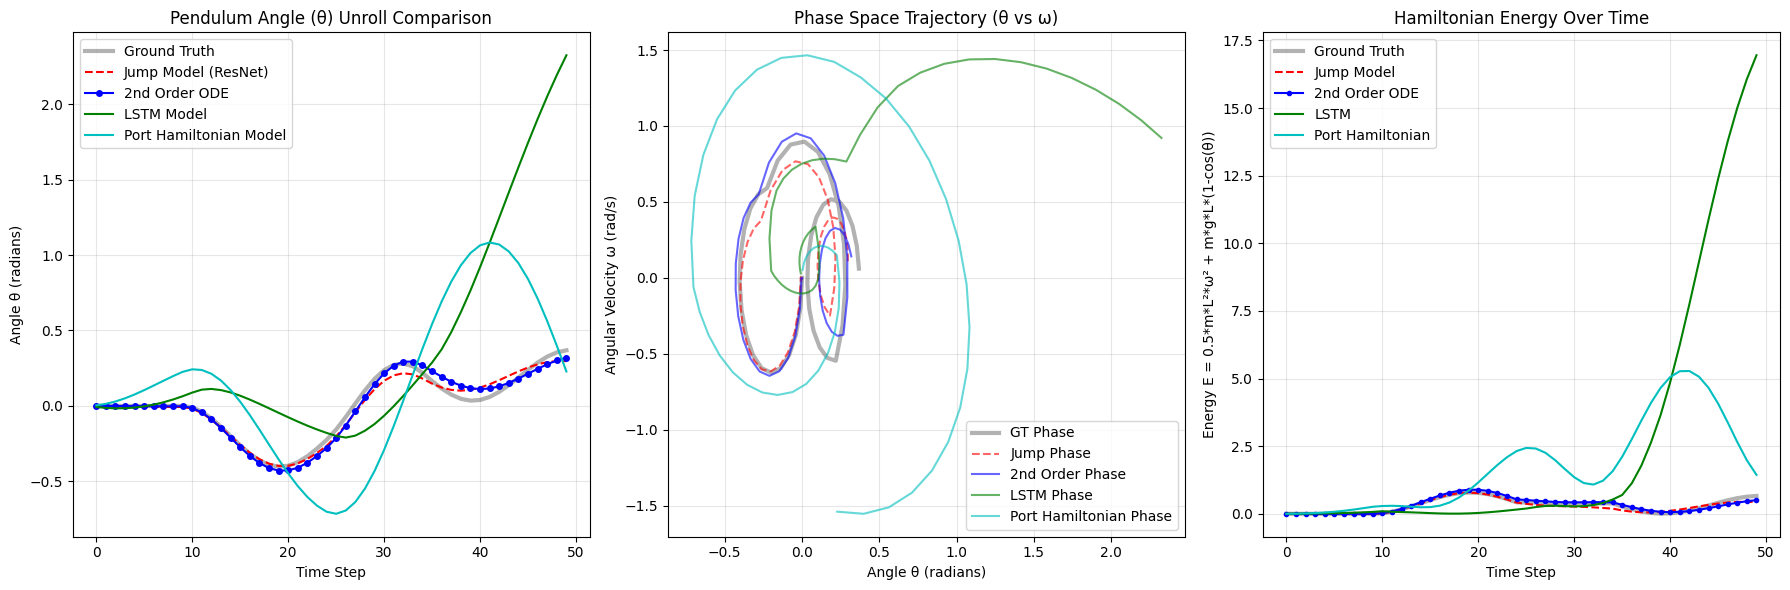

{'ground_truth': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.00988559, -0.19576554],
        [-0.03845399, -0.37063268],
        [-0.08275485, -0.5079127 ],
        [-0.13835211, -0.5948419 ],
        [-0.19978687, -0.62389004],
        [-0.26114035, -0.59345824],
        [-0.31663167, -0.5078009 ],
        [-0.36116567, -0.3762263 ],
        [-0.39077994, -0.21182522],
        [-0.40295056, -0.03005335],
        [-0.39676163,  0.15259346],
        [-0.3729492 ,  0.31976366],
        [-0.33382994,  0.45638368],
        [-0.28311592,  0.5498429 ],
        [-0.22560312,  0.5912302 ],
        [-0.1568626 ,  0.7722328 ],
        [-0.07368709,  0.87757355],
        [ 0.

In [81]:
# Visualize Pendulum Predictions (trained dt=0.1)
visualize_pendulum_unroll(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.1,
    c=0.1,
    torque_range=(-2, 2),
)

## Variable dt Generalization Tests

Test how well models generalize to different time steps than they were trained on (trained on dt=0.1)

### dt = 0.05 (Smaller timestep)

Simulating Pendulum Unroll for 50 steps...


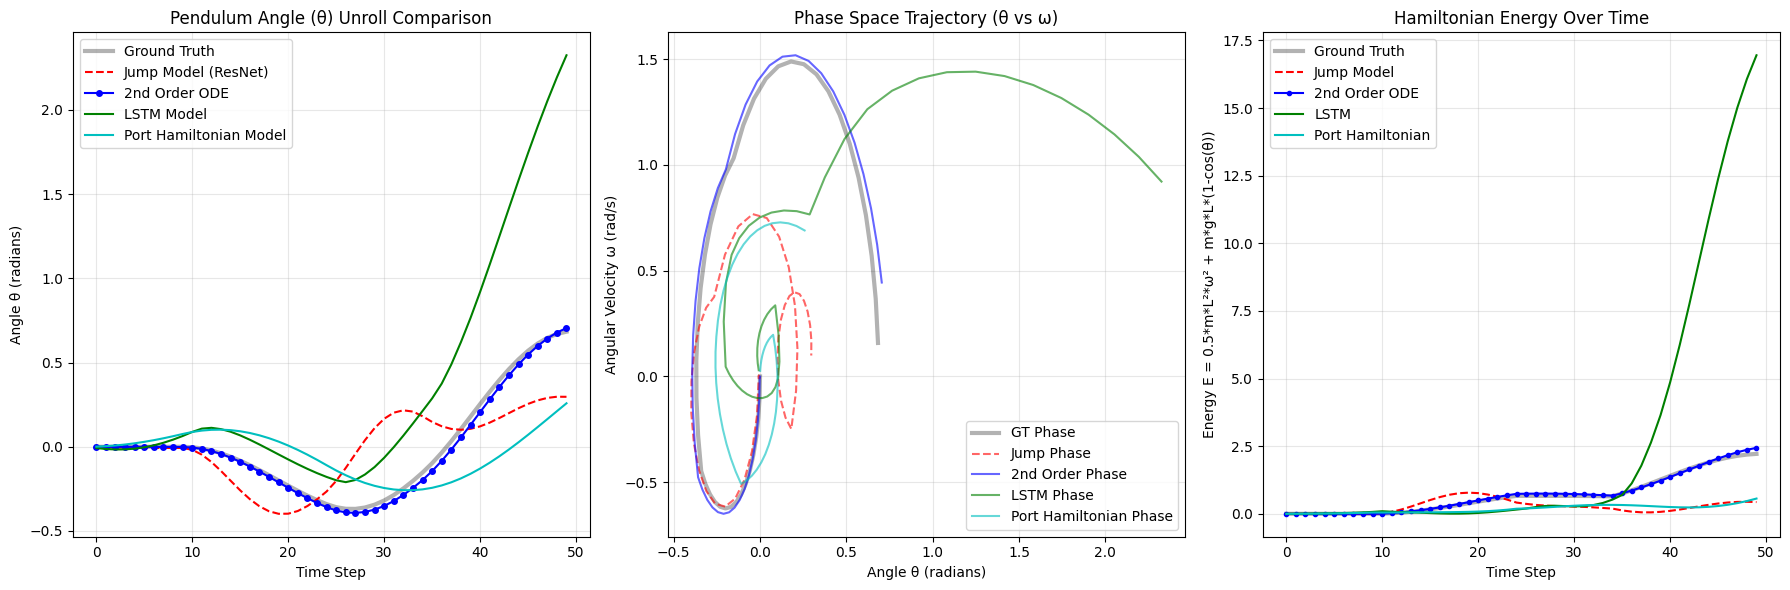

{'ground_truth': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.00249074, -0.0993432 ],
        [-0.0098856 , -0.19576557],
        [-0.02197956, -0.28692806],
        [-0.03845401, -0.37063268],
        [-0.05888506, -0.44487858],
        [-0.08275484, -0.5079128 ],
        [-0.10946503, -0.55827594],
        [-0.13835233, -0.59484166],
        [-0.16870624, -0.616843  ],
        [-0.19978718, -0.6238901 ],
        [-0.23084566, -0.615974  ],
        [-0.26114106, -0.5934579 ],
        [-0.28995982, -0.5570554 ],
        [-0.3166322 , -0.50780004],
        [-0.34054703, -0.44700554],
        [-0.35867482, -0.27685618],
        [-0.36814117, -0.10122062],
        [-0.

In [82]:
visualize_pendulum_unroll(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.05,
    c=0.1,
    torque_range=(-2, 2),
)

### dt = 0.2 (Larger timestep)

Simulating Pendulum Unroll for 50 steps...


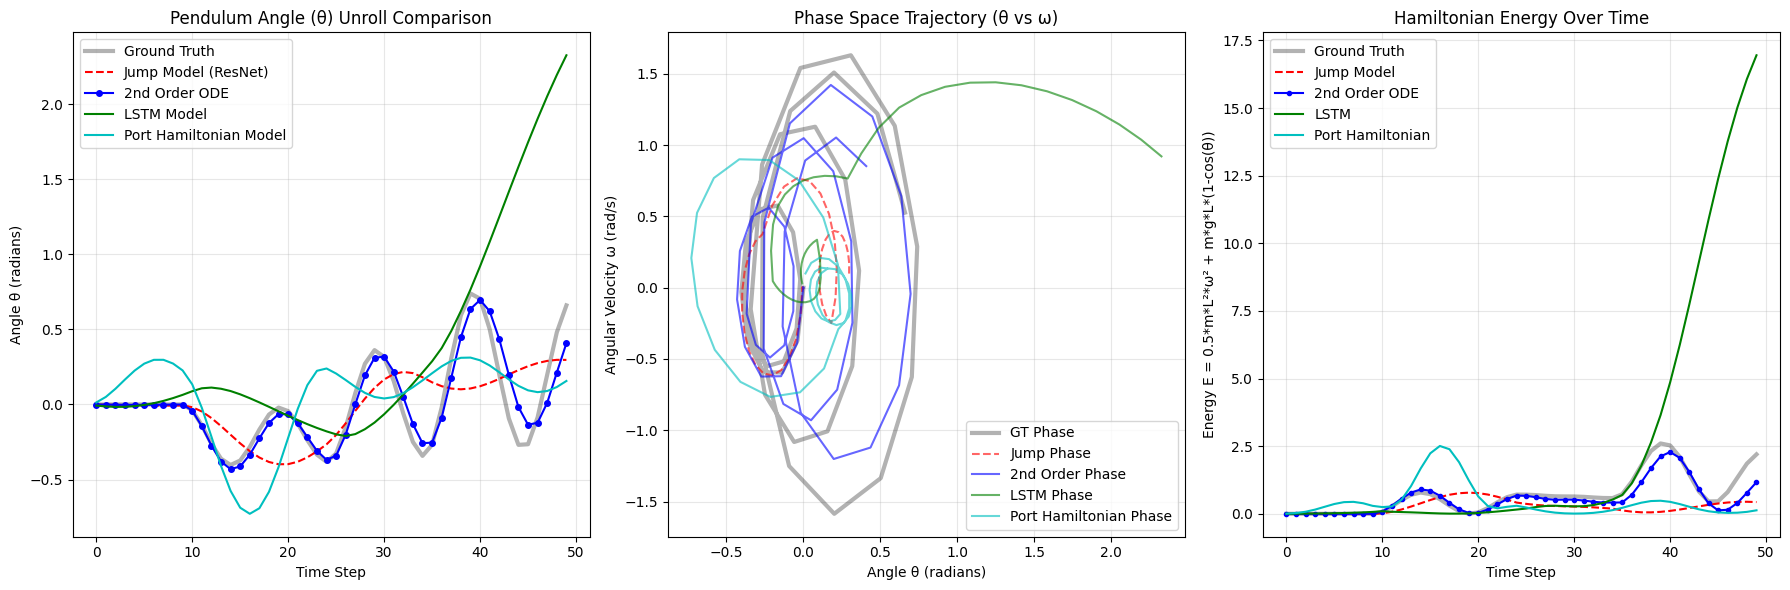

{'ground_truth': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.03845399, -0.3706327 ],
        [-0.13835235, -0.59484226],
        [-0.26114118, -0.5934584 ],
        [-0.36116654, -0.37622526],
        [-0.40295103, -0.03005102],
        [-0.37294903,  0.31976643],
        [-0.2831145 ,  0.5498463 ],
        [-0.16674761,  0.5764151 ],
        [-0.06700788,  0.38901082],
        [-0.02073719,  0.0595919 ],
        [-0.04423689, -0.285691  ],
        [-0.12730229, -0.51694113],
        [-0.23769096, -0.55111176],
        [-0.33409378, -0.38307133],
        [-0.3819279 , -0.08156444],
        [-0.3266559 ,  0.6149242 ],
        [-0.15178214,  1.0764507 ],
        [ 0.

In [83]:
visualize_pendulum_unroll(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.2,
    c=0.1,
    torque_range=(-2, 2),
)

### dt = 0.5 (Much larger timestep)

Simulating Pendulum Unroll for 50 steps...


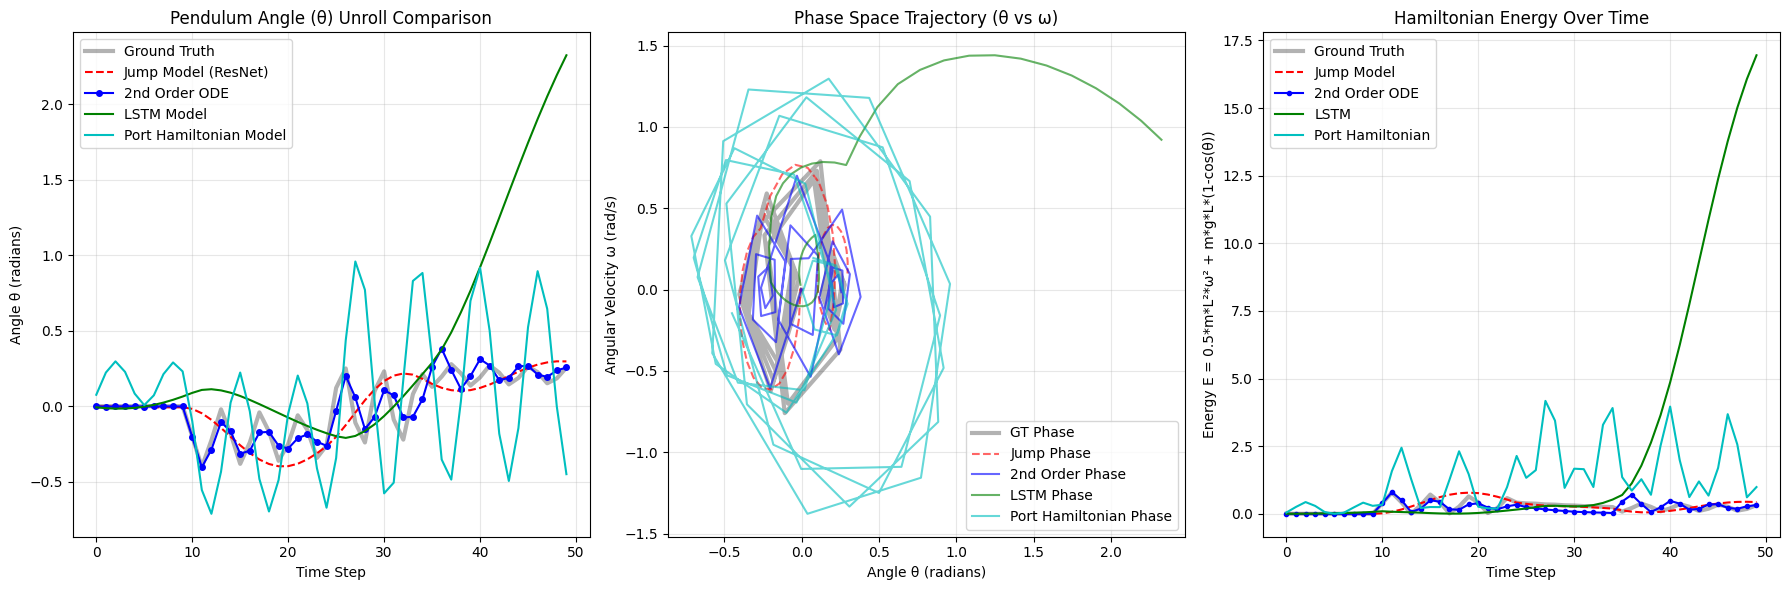

{'ground_truth': array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.1997872 , -0.6238906 ],
        [-0.40295094, -0.03005138],
        [-0.22560185,  0.5912321 ],
        [-0.02073724,  0.05959345],
        [-0.18163952, -0.56094736],
        [-0.3819282 , -0.08156577],
        [-0.24055883,  0.5276961 ],
        [-0.04104725,  0.10567489],
        [-0.16770183, -0.49926516],
        [-0.36165476, -0.12117725],
        [-0.2518112 ,  0.46660823],
        [-0.0605291 ,  0.14033054],
        [-0.15731631, -0.44005919],
        [-0.34242487, -0.15068722],
        [-0.25995627,  0.40880698],
        [ 0.12106328,  0.78917557],
        [ 0.2502182 , -0.36946723],
        [-0.

In [84]:
visualize_pendulum_unroll(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
    treatment={0: 15, 1: 10, 2: 15},
    dt=0.5,
    c=0.1,
    torque_range=(-2, 2),
)

## Test Set Sample Predictions

Plot position, phase space, and energy for a sample from the test set

Unrolling predictions for 100 steps...


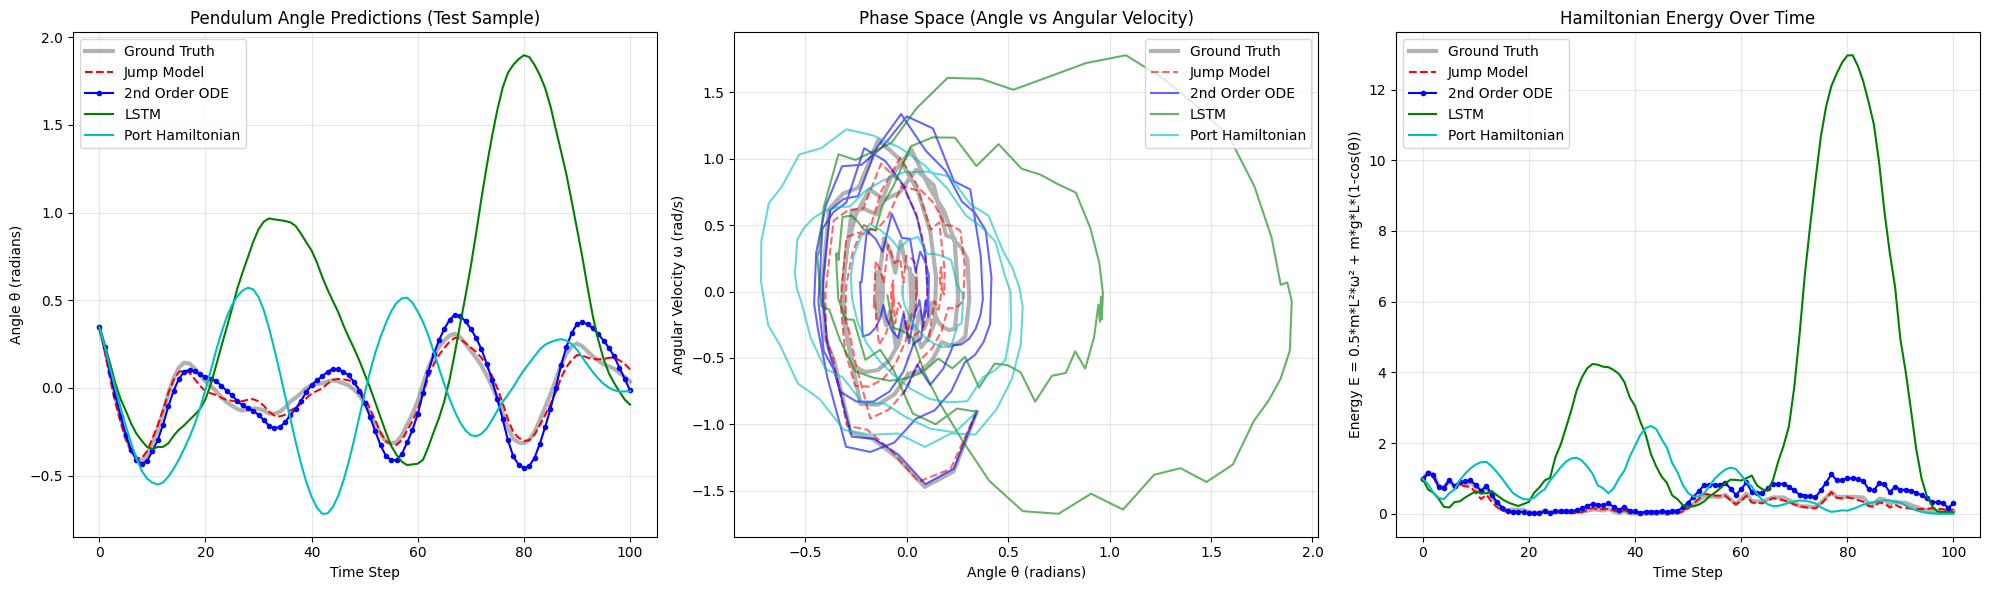

{'ground_truth': array([[ 0.34533784, -0.9051186 ],
        [ 0.2313477 , -1.3546423 ],
        [ 0.08889414, -1.4708527 ],
        [-0.04819347, -1.2495288 ],
        [-0.16704638, -1.1088638 ],
        [-0.27642015, -1.0613668 ],
        [-0.35643375, -0.5290192 ],
        [-0.4007958 , -0.35232508],
        [-0.41619387,  0.04476539],
        [-0.38252163,  0.620834  ],
        [-0.31408703,  0.73678136],
        [-0.23752452,  0.7821852 ],
        [-0.14048003,  1.1413757 ],
        [-0.03286517,  0.9940767 ],
        [ 0.0552907 ,  0.7557549 ],
        [ 0.11609259,  0.45182684],
        [ 0.1445053 ,  0.11344429],
        [ 0.13874315, -0.22611833],
        [ 0.11014839, -0.34057975],
        [ 0.07182209, -0.41931817],
        [ 0.0375255 , -0.26176366],
        [ 0.01033404, -0.27753806],
        [-0.017077  , -0.2662483 ],
        [-0.0518968 , -0.423691  ],
        [-0.08065964, -0.14819208],
        [-0.10097258, -0.2542433 ],
        [-0.12077145, -0.13906616],
        [-0.

In [85]:
# Plot predictions for test sample 0
plot_pendulum_test_sample(
    pendulum_jump_model,
    pendulum_traj_model,
    pendulum_lstm_model,
    pendulum_port_hamiltonian_model,
    dataset=pendulum_dataset,
    sample_idx=0,
    dt=0.1,
    c=0.1,
    torque_range=(-2, 2),
)

# C. The "Spaceship" Problem (Modified 2-Body)
Transform the 2-body problem into a navigation task. Treat one body as a massive "Star" (uncontrollable) and the other as a "Ship" (controllable).
Physics Modification:
Original: Gravity only.
Modified: $\ddot{q}_{ship} = F_{gravity} + u(t)$
Action Space: Continuous vector $u \in \mathbb{R}^2$ representing thruster firing direction and magnitude.
Why use it: This tests vector-valued actions in a chaotic system. It requires the model to decouple the conservative force (gravity) from the non-conservative force (thrusters).
Test Case: "Station Keeping." Can the model predict a sequence of actions that prevents the ship from crashing into the star?

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from tqdm import tqdm


# ==========================================
# 1. FORCED TWO-BODY SPACESHIP PHYSICS ENGINE
# ==========================================
class ForcedTwoBodySpaceship:
    def __init__(self, G=1.0, M_star=10.0, thruster_magnitude=0.5):
        """
        Two-body problem where one body (star) is fixed and massive,
        and the other (ship) can be controlled with thrusters.

        Args:
            G: Gravitational constant
            M_star: Mass of the star (fixed at origin)
            thruster_magnitude: Magnitude of thruster force
        """
        self.G = G
        self.M_star = M_star
        self.thruster_magnitude = thruster_magnitude

        # Map Action Index -> Thruster Force Vector (2D)
        # 8 directions + no action = 9 actions
        angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
        self.thruster_map = {
            0: np.array([0.0, 0.0]),  # No thrust
            1: thruster_magnitude
            * np.array([np.cos(angles[0]), np.sin(angles[0])]),  # Right
            2: thruster_magnitude
            * np.array([np.cos(angles[1]), np.sin(angles[1])]),  # Up-right
            3: thruster_magnitude
            * np.array([np.cos(angles[2]), np.sin(angles[2])]),  # Up
            4: thruster_magnitude
            * np.array([np.cos(angles[3]), np.sin(angles[3])]),  # Up-left
            5: thruster_magnitude
            * np.array([np.cos(angles[4]), np.sin(angles[4])]),  # Left
            6: thruster_magnitude
            * np.array([np.cos(angles[5]), np.sin(angles[5])]),  # Down-left
            7: thruster_magnitude
            * np.array([np.cos(angles[6]), np.sin(angles[6])]),  # Down
            8: thruster_magnitude
            * np.array([np.cos(angles[7]), np.sin(angles[7])]),  # Down-right
        }

    def step(self, state, action_idx, dt=0.1):
        """
        Precise integration of the ground truth physics
        state: [q_x, q_y, v_x, v_y] where q is position, v is velocity
        Star is fixed at origin (0, 0)
        """
        u_val = torch.tensor(
            self.thruster_map[action_idx], dtype=torch.float32
        )

        def dynamics(t, s):
            q_x, q_y, v_x, v_y = s[..., 0], s[..., 1], s[..., 2], s[..., 3]

            # Position derivative
            dq_x_dt = v_x
            dq_y_dt = v_y

            # Distance from star (at origin)
            r_squared = q_x**2 + q_y**2
            r = torch.sqrt(
                r_squared + 1e-6
            )  # Add small epsilon to avoid division by zero

            # Gravitational force: F_gravity = -G*M_star * q / r^3
            F_gravity_x = -(self.G * self.M_star * q_x) / (r**3)
            F_gravity_y = -(self.G * self.M_star * q_y) / (r**3)

            # Total acceleration: gravity + thruster
            dv_x_dt = F_gravity_x + u_val[0]
            dv_y_dt = F_gravity_y + u_val[1]

            return torch.stack([dq_x_dt, dq_y_dt, dv_x_dt, dv_y_dt], dim=-1)

        # Integrate exactly one step
        next_state = odeint(
            dynamics, state, torch.tensor([0.0, dt]), method="dopri5"
        )[-1]
        return next_state

    def get_energy(self, state):
        """
        Compute Hamiltonian energy: E = 0.5*m*v^2 - G*M_star*m/r
        For unit mass ship: E = 0.5*(v_x^2 + v_y^2) - G*M_star/r
        """
        q_x, q_y, v_x, v_y = (
            state[..., 0],
            state[..., 1],
            state[..., 2],
            state[..., 3],
        )
        r_squared = q_x**2 + q_y**2
        r = torch.sqrt(r_squared + 1e-6)

        kinetic = 0.5 * (v_x**2 + v_y**2)
        potential = -(self.G * self.M_star) / r
        return kinetic + potential


# ==========================================
# 2. SPACESHIP DATASET (Sequence Generation)
# ==========================================
class SpaceshipSequenceDataset(Dataset):
    def __init__(
        self,
        n_seqs=200,
        seq_len=20,
        dt=0.1,
        G=1.0,
        M_star=10.0,
        thruster_magnitude=0.5,
        initial_radius_range=(2.0, 5.0),
    ):
        self.data = []
        physics = ForcedTwoBodySpaceship(
            G=G, M_star=M_star, thruster_magnitude=thruster_magnitude
        )

        print(
            f"Generating {n_seqs} spaceship sequences of length {seq_len}..."
        )

        for _ in range(n_seqs):
            # Start at random position and velocity (circular orbit-like)
            r_init = np.random.uniform(
                initial_radius_range[0], initial_radius_range[1]
            )
            theta_init = np.random.uniform(0, 2 * np.pi)

            # Initial position
            q_x_init = r_init * np.cos(theta_init)
            q_y_init = r_init * np.sin(theta_init)

            # Initial velocity (circular orbit velocity with some randomness)
            v_orbit = np.sqrt(G * M_star / r_init)
            v_x_init = -v_orbit * np.sin(theta_init) + np.random.uniform(
                -0.5, 0.5
            )
            v_y_init = v_orbit * np.cos(theta_init) + np.random.uniform(
                -0.5, 0.5
            )

            state = torch.tensor([q_x_init, q_y_init, v_x_init, v_y_init])

            states = [state]
            actions = []

            # Generate Sequence
            for _ in range(seq_len):
                a = np.random.randint(0, 9)  # 9 actions: 0-8
                state = physics.step(state, a, dt)
                states.append(state)
                actions.append(a)

            # Store: (States[0:T], Actions[0:T], States[1:T+1])
            self.data.append(
                {
                    "states": torch.stack(states[:-1]).float(),  # Inputs
                    "actions": torch.tensor(actions).long(),
                    "targets": torch.stack(states[1:]).float(),  # Next steps
                }
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 3. SPACESHIP-SPECIFIC MODELS
# ==========================================


# --- Spaceship Second-Order ODE Model ---
class SpaceshipSecondOrderODENet(nn.Module):
    """
    Learns d/dt[q_x, q_y, v_x, v_y] = [v_x, v_y, a_x, a_y]
    where acceleration comes from gravity + thruster
    """

    def __init__(self, state_dim=4, action_dim=9, G=1.0, M_star=10.0):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 16)
        self.G = G
        self.M_star = M_star

        # Neural network to predict acceleration correction
        # Input: [q_x, q_y, v_x, v_y, action_emb] -> Output: [a_x, a_y]
        self.net = nn.Sequential(
            nn.Linear(state_dim + 16, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2),  # Output: 2D acceleration correction
        )

        # Learnable scaling for gravity prior
        self.gravity_scale = nn.Parameter(torch.tensor(1.0))

    def physics_prior(self, state, action_idx, thruster_map):
        """
        Physics prior: gravity force + thruster force
        state: [q_x, q_y, v_x, v_y]
        """
        q_x, q_y = state[..., 0:1], state[..., 1:2]

        # Distance from star (at origin)
        r_squared = q_x**2 + q_y**2
        r = torch.sqrt(r_squared + 1e-6)

        # Gravitational acceleration: a_gravity = -G*M_star * q / r^3
        a_gravity_x = -(self.G * self.M_star * q_x) / (r**3)
        a_gravity_y = -(self.G * self.M_star * q_y) / (r**3)

        # Thruster force (from action) - vectorized for batches
        # Create a tensor of all thruster vectors
        thruster_tensor = torch.tensor(
            [thruster_map[i] for i in range(len(thruster_map))],
            dtype=torch.float32,
            device=state.device,
        )  # Shape: [9, 2]

        # Index into thruster tensor: [batch_size, 2]
        u_vals = thruster_tensor[action_idx]

        # Split into x and y components: [batch_size, 1] each
        u_x = u_vals[:, 0:1]
        u_y = u_vals[:, 1:2]

        # Total acceleration from prior
        # All shapes are compatible: scalar * [batch, 1] + [batch, 1] = [batch, 1]
        a_x = self.gravity_scale * a_gravity_x + u_x
        a_y = self.gravity_scale * a_gravity_y + u_y

        return torch.cat([a_x, a_y], dim=-1)

    def forward(self, t, state, action_emb, action_idx, thruster_map):
        q_x, q_y, v_x, v_y = (
            state[..., 0:1],
            state[..., 1:2],
            state[..., 2:3],
            state[..., 3:4],
        )

        # 1. Physics Prior (gravity + thruster)
        prior_acc = self.physics_prior(state, action_idx, thruster_map)

        # 2. Neural Correction
        nn_input = torch.cat([q_x, q_y, v_x, v_y, action_emb], dim=-1)
        correction_acc = self.net(nn_input)

        # 3. Total Acceleration
        # total_acc = prior_acc + correction_acc
        total_acc = correction_acc

        return torch.cat([v_x, v_y, total_acc], dim=-1)


# Wrapper for spaceship ODE
class SpaceshipTrajectoryMatchingModel(nn.Module):
    def __init__(self, ode_func, thruster_map):
        super().__init__()
        self.ode_func = ode_func
        self.thruster_map = thruster_map

    def forward(self, start_state, action_indices, dt=0.1):
        act_emb = self.ode_func.act_emb(action_indices)

        def func(t, y):
            return self.ode_func(
                t, y, act_emb, action_indices, self.thruster_map
            )

        t_span = torch.tensor([0.0, dt], device=start_state.device)
        next_state = odeint(func, start_state, t_span, method="rk4")[-1]
        return next_state


# --- Spaceship Port Hamiltonian Model ---
class SpaceshipPortHamiltonianModel(nn.Module):
    """
    Port-Hamiltonian model for spaceship: learns H(q, p) and input port G
    State: [q_x, q_y, v_x, v_y] where we treat v as momentum (unit mass)
    """

    def __init__(self, state_dim=4, action_dim=9, G=1.0, M_star=10.0):
        super().__init__()
        self.act_emb = nn.Embedding(action_dim, 16)
        self.G_const = G
        self.M_star = M_star

        # Hamiltonian network: H(q, p) -> scalar
        self.H_net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Softplus(),
            nn.Linear(128, 128),
            nn.Softplus(),
            nn.Linear(128, 1),
        )

        # Dissipation (optional, set to zero for conservative gravity)
        self.R = torch.tensor(0.0)

        # Input port: maps action embedding to 2D force (for 2D thruster)
        self.G_net = nn.Sequential(
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 2),  # Output: 2D force vector
        )

    def forward(self, t, state, action_emb, action_idx):
        if not state.requires_grad:
            state.requires_grad_(True)

        with torch.enable_grad():
            H = self.H_net(state)
            dH_dstate = torch.autograd.grad(
                H, state, torch.ones_like(H), create_graph=True
            )[0]
            # Split into position and momentum gradients
            dH_dq_x, dH_dq_y = dH_dstate[..., 0:1], dH_dstate[..., 1:2]
            dH_dv_x, dH_dv_y = dH_dstate[..., 2:3], dH_dstate[..., 3:4]

        # Dissipation (zero for conservative gravity)
        R = torch.abs(self.R)

        # External force from thruster
        G_u = self.G_net(action_emb)  # Shape: [Batch, 2]

        # Port-Hamiltonian dynamics:
        # dq/dt = dH/dp (velocity)
        # dp/dt = -dH/dq - R*dH/dp + G*u (force)
        dq_x_dt = dH_dv_x
        dq_y_dt = dH_dv_y
        dp_x_dt = -dH_dq_x - R * dH_dv_x + G_u[..., 0:1]
        dp_y_dt = -dH_dq_y - R * dH_dv_y + G_u[..., 1:2]

        return torch.cat([dq_x_dt, dq_y_dt, dp_x_dt, dp_y_dt], dim=-1)


# ==========================================
# 4. SPACESHIP TRAINING LOOP
# ==========================================
def train_spaceship_experiment(
    dataset,
    epochs=40,
    batch_size=32,
    lr=1e-3,
    verbose=False,
    G=1.0,
    M_star=10.0,
    thruster_magnitude=0.5,
):
    # split dataset into train and test
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * 0.8)]
    test_indices = perm[int(len_dataset * 0.8) :]
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create thruster map (same as in ForcedTwoBodySpaceship)
    angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
    thruster_map = {
        0: np.array([0.0, 0.0]),  # No thrust
        1: thruster_magnitude
        * np.array([np.cos(angles[0]), np.sin(angles[0])]),
        2: thruster_magnitude
        * np.array([np.cos(angles[1]), np.sin(angles[1])]),
        3: thruster_magnitude
        * np.array([np.cos(angles[2]), np.sin(angles[2])]),
        4: thruster_magnitude
        * np.array([np.cos(angles[3]), np.sin(angles[3])]),
        5: thruster_magnitude
        * np.array([np.cos(angles[4]), np.sin(angles[4])]),
        6: thruster_magnitude
        * np.array([np.cos(angles[5]), np.sin(angles[5])]),
        7: thruster_magnitude
        * np.array([np.cos(angles[6]), np.sin(angles[6])]),
        8: thruster_magnitude
        * np.array([np.cos(angles[7]), np.sin(angles[7])]),
    }

    # Models (4D state: [q_x, q_y, v_x, v_y], 9 actions)
    jump_model = JumpModel(state_dim=4, action_dim=9)
    lstm_model = LSTMModel(state_dim=4, action_dim=9)

    # Spaceship-specific second-order ODE model
    ode_core = SpaceshipSecondOrderODENet(
        state_dim=4, action_dim=9, G=G, M_star=M_star
    )
    traj_model = SpaceshipTrajectoryMatchingModel(ode_core, thruster_map)

    # Spaceship Port Hamiltonian model
    port_hamiltonian_ode = SpaceshipPortHamiltonianModel(
        state_dim=4, action_dim=9, G=G, M_star=M_star
    )
    port_hamiltonian_model = TrajectoryMatchingModel(port_hamiltonian_ode)

    opt_jump = optim.Adam(jump_model.parameters(), lr=lr)
    opt_traj = optim.Adam(traj_model.parameters(), lr=lr)
    opt_lstm = optim.Adam(lstm_model.parameters(), lr=lr)
    opt_port_hamiltonian = optim.Adam(
        port_hamiltonian_model.parameters(), lr=lr
    )

    def train_step(batch):
        states = batch["states"]  # [B, T, 4]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 4]

        # --- 1. Train Jump Model (One-Step MSE) ---
        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        opt_jump.zero_grad()
        loss_j.backward()
        opt_jump.step()

        opt_lstm.zero_grad()
        loss_lstm.backward()
        opt_lstm.step()

        # --- 2. Train Trajectory Models (Sequential Shooting) ---
        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        opt_traj.zero_grad()
        loss_t.backward()
        opt_traj.step()

        # --- 3. Train Port Hamiltonian Model ---
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        opt_port_hamiltonian.zero_grad()
        loss_port_hamiltonian.backward()
        opt_port_hamiltonian.step()

        return loss_j, loss_t, loss_lstm, loss_port_hamiltonian

    @torch.no_grad()
    def test_step(batch):
        states = batch["states"]  # [B, T, 4]
        actions = batch["actions"]  # [B, T]
        targets = batch["targets"]  # [B, T, 4]

        B, T, D = states.shape
        flat_s = states.view(-1, D)
        flat_a = actions.view(-1)
        flat_t = targets.view(-1, D)

        pred_j = jump_model(flat_s, flat_a)
        loss_j = ((pred_j - flat_t) ** 2).mean()

        pred_lstm = lstm_model(states, actions)
        loss_lstm = ((pred_lstm - targets) ** 2).mean()

        pred_next = traj_model(flat_s, flat_a, dt=0.1)
        loss_t = ((pred_next - flat_t) ** 2).mean()

        # Port Hamiltonian model
        pred_port_hamiltonian = port_hamiltonian_model(flat_s, flat_a, dt=0.1)
        loss_port_hamiltonian = ((pred_port_hamiltonian - flat_t) ** 2).mean()

        return loss_j, loss_t, loss_lstm, loss_port_hamiltonian

    print("Training Spaceship Models...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {1} | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | PHNN: 0.0000",
    )
    for epoch in range(1, epochs + 1):
        total_j, total_t, total_lstm, total_port_hamiltonian = (
            0,
            0,
            0,
            0,
        )

        for batch in train_loader:
            loss_j, loss_t, loss_lstm, loss_port_hamiltonian = train_step(
                batch
            )
            total_j += loss_j.item()
            total_t += loss_t.item()
            total_lstm += loss_lstm.item()
            total_port_hamiltonian += loss_port_hamiltonian.item()

        epoch_loss_j = total_j / len(train_loader)
        epoch_loss_t = total_t / len(train_loader)
        epoch_loss_lstm = total_lstm / len(train_loader)
        epoch_loss_port_hamiltonian = total_port_hamiltonian / len(
            train_loader
        )
        pbar.set_description(
            f"Epoch {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | PHNN: {epoch_loss_port_hamiltonian:.4f}"
        )
        if verbose:
            print(
                f"Ep {epoch} | Jump: {epoch_loss_j:.4f} | Traj: {epoch_loss_t:.4f} | LSTM: {epoch_loss_lstm:.4f} | PHNN: {epoch_loss_port_hamiltonian:.4f}",
                flush=True,
            )

    # test set
    print("Testing Spaceship Models...")
    total_j, total_t, total_lstm, total_port_hamiltonian = (
        0,
        0,
        0,
        0,
    )
    for batch in test_loader:
        loss_j, loss_t, loss_lstm, loss_port_hamiltonian = test_step(batch)
        total_j += loss_j.item()
        total_t += loss_t.item()
        total_lstm += loss_lstm.item()
        total_port_hamiltonian += loss_port_hamiltonian.item()

    test_loss_j = total_j / len(test_loader)
    test_loss_t = total_t / len(test_loader)
    test_loss_lstm = total_lstm / len(test_loader)
    test_loss_port_hamiltonian = total_port_hamiltonian / len(test_loader)
    print(
        f"Test | Jump: {test_loss_j:.4f} | Traj: {test_loss_t:.4f} | LSTM: {test_loss_lstm:.4f} | PHNN: {test_loss_port_hamiltonian:.4f}"
    )

    return (
        jump_model,
        traj_model,
        lstm_model,
        port_hamiltonian_model,
    )


# ==========================================
# 5. SPACESHIP ENERGY COMPUTATION
# ==========================================
def compute_spaceship_energy(states, G=1.0, M_star=10.0):
    """
    Compute Hamiltonian energy from state predictions.

    Args:
        states: [T, 4] array where states[:, 0:2] = position (q_x, q_y), states[:, 2:4] = velocity (v_x, v_y)
        G: Gravitational constant (default 1.0)
        M_star: Mass of star (default 10.0)

    Returns:
        energies: [T] array of energy values
    """
    q_x = states[:, 0]
    q_y = states[:, 1]
    v_x = states[:, 2]
    v_y = states[:, 3]

    r_squared = q_x**2 + q_y**2
    r = np.sqrt(r_squared + 1e-6)

    kinetic = 0.5 * (v_x**2 + v_y**2)
    potential = -(G * M_star) / r
    return kinetic + potential


# ==========================================
# 6. SPACESHIP VISUALIZATION (UNROLL)
# ==========================================
def visualize_spaceship_unroll(
    jump_model,
    traj_model,
    lstm_model,
    port_hamiltonian_model,
    treatment={0: 10, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5},
    dt=0.1,
    thruster_magnitude=0.5,
    history_len=4,
    G=1.0,
    M_star=10.0,
    initial_state=None,
):
    physics = ForcedTwoBodySpaceship(
        G=G, M_star=M_star, thruster_magnitude=thruster_magnitude
    )

    # 1. Initial state (circular orbit if not provided)
    if initial_state is None:
        r_init = 3.0
        theta_init = 0.0
        q_x_init = r_init * np.cos(theta_init)
        q_y_init = r_init * np.sin(theta_init)
        v_orbit = np.sqrt(G * M_star / r_init)
        v_x_init = -v_orbit * np.sin(theta_init)
        v_y_init = v_orbit * np.cos(theta_init)
        state = torch.tensor(
            [q_x_init, q_y_init, v_x_init, v_y_init], dtype=torch.float32
        )
    else:
        state = initial_state

    curr_gt = state
    curr_jump = state.unsqueeze(0)
    curr_traj = state.unsqueeze(0)
    curr_port_hamiltonian = state.unsqueeze(0)

    # Initialize LSTM history buffer
    lstm_state_buffer = [state.unsqueeze(0)] * history_len
    lstm_action_buffer = [torch.tensor([0])] * history_len

    # 2. Define Action Sequence
    actions = []
    for action_idx, count in treatment.items():
        actions.extend([action_idx] * count)

    (
        gt_hist,
        jump_hist,
        traj_hist,
        lstm_hist,
        port_hamiltonian_hist,
    ) = ([], [], [], [], [])

    print(f"Simulating Spaceship Unroll for {len(actions)} steps...")

    # 3. Unroll Loop
    for act_idx in actions:
        # A. Ground Truth Step
        curr_gt = physics.step(curr_gt, act_idx, dt)
        gt_hist.append(curr_gt.numpy())

        # B. Jump Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_jump = jump_model(curr_jump, act_tensor)
            jump_hist.append(curr_jump[0].numpy())

        # C. Trajectory Matching Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            traj_hist.append(curr_traj[0].numpy())

        # D. LSTM Step - Use history buffer
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            lstm_hist.append(curr_lstm[0].numpy())

            # Update history buffer
            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

        # E. Port Hamiltonian Model Step
        with torch.no_grad():
            act_tensor = torch.tensor([act_idx])
            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            port_hamiltonian_hist.append(curr_port_hamiltonian[0].numpy())

    # 4. Convert to numpy arrays
    gt_hist = np.array(gt_hist)
    jump_hist = np.array(jump_hist)
    traj_hist = np.array(traj_hist)
    lstm_hist = np.array(lstm_hist)
    port_hamiltonian_hist = np.array(port_hamiltonian_hist)

    # Compute energies
    energy_gt = compute_spaceship_energy(gt_hist, G=G, M_star=M_star)
    energy_jump = compute_spaceship_energy(jump_hist, G=G, M_star=M_star)
    energy_traj = compute_spaceship_energy(traj_hist, G=G, M_star=M_star)
    energy_lstm = compute_spaceship_energy(lstm_hist, G=G, M_star=M_star)
    energy_port_hamiltonian = compute_spaceship_energy(
        port_hamiltonian_hist, G=G, M_star=M_star
    )

    t_steps = np.arange(len(actions))

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Trajectory in 2D space (position)
    ax[0, 0].plot(0, 0, "yo", markersize=15, label="Star")
    ax[0, 0].plot(
        gt_hist[:, 0],
        gt_hist[:, 1],
        "k-",
        lw=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0, 0].plot(jump_hist[:, 0], jump_hist[:, 1], "r--", label="Jump Model")
    ax[0, 0].plot(
        traj_hist[:, 0], traj_hist[:, 1], "b-", label="2nd Order ODE"
    )
    ax[0, 0].plot(lstm_hist[:, 0], lstm_hist[:, 1], "g-", label="LSTM")
    ax[0, 0].plot(
        port_hamiltonian_hist[:, 0],
        port_hamiltonian_hist[:, 1],
        "c-",
        label="Port Hamiltonian",
    )
    ax[0, 0].set_title("Spaceship Trajectory (2D Position)")
    ax[0, 0].set_xlabel("X Position")
    ax[0, 0].set_ylabel("Y Position")
    ax[0, 0].legend()
    ax[0, 0].grid(True, alpha=0.3)
    ax[0, 0].set_aspect("equal")

    # Plot 2: Phase Space (x position vs x velocity)
    ax[0, 1].plot(
        gt_hist[:, 0], gt_hist[:, 2], "k-", lw=3, alpha=0.3, label="GT Phase"
    )
    ax[0, 1].plot(
        jump_hist[:, 0], jump_hist[:, 2], "r--", alpha=0.6, label="Jump Phase"
    )
    ax[0, 1].plot(
        traj_hist[:, 0],
        traj_hist[:, 2],
        "b-",
        alpha=0.6,
        label="2nd Order Phase",
    )
    ax[0, 1].plot(
        lstm_hist[:, 0], lstm_hist[:, 2], "g-", alpha=0.6, label="LSTM Phase"
    )
    ax[0, 1].plot(
        port_hamiltonian_hist[:, 0],
        port_hamiltonian_hist[:, 2],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian Phase",
    )
    ax[0, 1].set_title("Phase Space (X Position vs X Velocity)")
    ax[0, 1].set_xlabel("X Position")
    ax[0, 1].set_ylabel("X Velocity")
    ax[0, 1].legend()
    ax[0, 1].grid(True, alpha=0.3)

    # Plot 3: Distance from star over time
    distance_gt = np.sqrt(gt_hist[:, 0] ** 2 + gt_hist[:, 1] ** 2)
    distance_jump = np.sqrt(jump_hist[:, 0] ** 2 + jump_hist[:, 1] ** 2)
    distance_traj = np.sqrt(traj_hist[:, 0] ** 2 + traj_hist[:, 1] ** 2)
    distance_lstm = np.sqrt(lstm_hist[:, 0] ** 2 + lstm_hist[:, 1] ** 2)
    distance_port_hamiltonian = np.sqrt(
        port_hamiltonian_hist[:, 0] ** 2 + port_hamiltonian_hist[:, 1] ** 2
    )

    ax[1, 0].plot(
        t_steps, distance_gt, "k-", lw=3, alpha=0.3, label="Ground Truth"
    )
    ax[1, 0].plot(t_steps, distance_jump, "r--", label="Jump Model")
    ax[1, 0].plot(t_steps, distance_traj, "b-", label="2nd Order ODE")
    ax[1, 0].plot(t_steps, distance_lstm, "g-", label="LSTM")
    ax[1, 0].plot(
        t_steps, distance_port_hamiltonian, "c-", label="Port Hamiltonian"
    )
    ax[1, 0].set_title("Distance from Star Over Time")
    ax[1, 0].set_xlabel("Time Step")
    ax[1, 0].set_ylabel("Distance r")
    ax[1, 0].legend()
    ax[1, 0].grid(True, alpha=0.3)

    # Plot 4: Energy vs Time
    ax[1, 1].plot(
        t_steps, energy_gt, "k-", linewidth=3, alpha=0.3, label="Ground Truth"
    )
    ax[1, 1].plot(t_steps, energy_jump, "r--", label="Jump Model")
    ax[1, 1].plot(t_steps, energy_traj, "b-", label="2nd Order ODE")
    ax[1, 1].plot(t_steps, energy_lstm, "g-", label="LSTM")
    ax[1, 1].plot(
        t_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )
    ax[1, 1].set_title("Hamiltonian Energy Over Time")
    ax[1, 1].set_xlabel("Time Step")
    ax[1, 1].set_ylabel("Energy E = 0.5*v² - G*M_star/r")
    ax[1, 1].legend()
    ax[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_hist,
        "jump": jump_hist,
        "traj": traj_hist,
        "lstm": lstm_hist,
        "port_hamiltonian": port_hamiltonian_hist,
        "energies": {
            "gt": energy_gt,
            "jump": energy_jump,
            "traj": energy_traj,
            "lstm": energy_lstm,
            "port_hamiltonian": energy_port_hamiltonian,
        },
    }


# ==========================================
# 7. PLOT SPACESHIP TEST SET SAMPLE PREDICTIONS
# ==========================================
def plot_spaceship_test_sample(
    jump_model,
    traj_model,
    lstm_model,
    port_hamiltonian_model,
    dataset=None,
    sample_idx=0,
    dt=0.1,
    thruster_magnitude=0.5,
    history_len=4,
    G=1.0,
    M_star=10.0,
):
    """
    Plot position, phase space, distance, and energy predictions for a sample from the test set.
    """
    from torch.utils.data import DataLoader

    if dataset is None:
        raise ValueError("Dataset must be provided")

    # Get test sample
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    test_indices = perm[int(len_dataset * 0.8) :]
    test_sample = dataset[test_indices[sample_idx]]

    # Extract ground truth data
    gt_states = test_sample["states"]
    gt_targets = test_sample["targets"]
    actions = test_sample["actions"]

    gt_trajectory = torch.cat([gt_states[0:1], gt_targets], dim=0)

    # Initialize model states
    start_state = gt_states[0:1]

    curr_jump = start_state.clone()
    curr_traj = start_state.clone()
    curr_port_hamiltonian = start_state.clone()

    # LSTM history buffer
    lstm_state_buffer = [start_state] * history_len
    lstm_action_buffer = [torch.tensor([0])] * history_len

    # Storage for predictions
    pred_jump = [start_state[0].numpy()]
    pred_traj = [start_state[0].numpy()]
    pred_lstm = [start_state[0].numpy()]
    pred_port_hamiltonian = [start_state[0].numpy()]

    # Unroll predictions
    T = len(actions)
    print(f"Unrolling predictions for {T} steps...")

    for t in range(T):
        act_idx = actions[t].item()
        act_tensor = torch.tensor([act_idx])

        with torch.no_grad():
            curr_jump = jump_model(curr_jump, act_tensor)
            pred_jump.append(curr_jump[0].numpy())

            curr_traj = traj_model(curr_traj, act_tensor, dt=dt)
            pred_traj.append(curr_traj[0].numpy())

            state_seq = torch.cat(lstm_state_buffer, dim=0).unsqueeze(0)
            action_seq = torch.cat(lstm_action_buffer, dim=0).unsqueeze(0)
            pred_seq = lstm_model(state_seq, action_seq)
            curr_lstm = pred_seq[:, -1, :]
            pred_lstm.append(curr_lstm[0].numpy())

            lstm_state_buffer.append(curr_lstm)
            lstm_action_buffer.append(act_tensor)
            if len(lstm_state_buffer) > history_len:
                lstm_state_buffer.pop(0)
                lstm_action_buffer.pop(0)

            curr_port_hamiltonian = port_hamiltonian_model(
                curr_port_hamiltonian, act_tensor, dt=dt
            )
            pred_port_hamiltonian.append(curr_port_hamiltonian[0].numpy())

    # Convert to numpy arrays
    pred_jump = np.array(pred_jump)
    pred_traj = np.array(pred_traj)
    pred_lstm = np.array(pred_lstm)
    pred_port_hamiltonian = np.array(pred_port_hamiltonian)
    gt_trajectory_np = gt_trajectory.numpy()

    # Compute energies
    energy_gt = compute_spaceship_energy(gt_trajectory_np, G=G, M_star=M_star)
    energy_jump = compute_spaceship_energy(pred_jump, G=G, M_star=M_star)
    energy_traj = compute_spaceship_energy(pred_traj, G=G, M_star=M_star)
    energy_lstm = compute_spaceship_energy(pred_lstm, G=G, M_star=M_star)
    energy_port_hamiltonian = compute_spaceship_energy(
        pred_port_hamiltonian, G=G, M_star=M_star
    )

    # Compute distances
    distance_gt = np.sqrt(
        gt_trajectory_np[:, 0] ** 2 + gt_trajectory_np[:, 1] ** 2
    )
    distance_jump = np.sqrt(pred_jump[:, 0] ** 2 + pred_jump[:, 1] ** 2)
    distance_traj = np.sqrt(pred_traj[:, 0] ** 2 + pred_traj[:, 1] ** 2)
    distance_lstm = np.sqrt(pred_lstm[:, 0] ** 2 + pred_lstm[:, 1] ** 2)
    distance_port_hamiltonian = np.sqrt(
        pred_port_hamiltonian[:, 0] ** 2 + pred_port_hamiltonian[:, 1] ** 2
    )

    time_steps = np.arange(len(gt_trajectory_np))

    # Create figure with 4 subplots
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Trajectory in 2D space
    ax[0, 0].plot(0, 0, "yo", markersize=15, label="Star")
    ax[0, 0].plot(
        gt_trajectory_np[:, 0],
        gt_trajectory_np[:, 1],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0, 0].plot(pred_jump[:, 0], pred_jump[:, 1], "r--", label="Jump Model")
    ax[0, 0].plot(
        pred_traj[:, 0], pred_traj[:, 1], "b-", label="2nd Order ODE"
    )
    ax[0, 0].plot(pred_lstm[:, 0], pred_lstm[:, 1], "g-", label="LSTM")
    ax[0, 0].plot(
        pred_port_hamiltonian[:, 0],
        pred_port_hamiltonian[:, 1],
        "c-",
        label="Port Hamiltonian",
    )

    ax[0, 0].set_title("Spaceship Trajectory (Test Sample)")
    ax[0, 0].set_xlabel("X Position")
    ax[0, 0].set_ylabel("Y Position")
    ax[0, 0].legend()
    ax[0, 0].grid(True, alpha=0.3)
    ax[0, 0].set_aspect("equal")

    # Plot 2: Phase Space
    ax[0, 1].plot(
        gt_trajectory_np[:, 0],
        gt_trajectory_np[:, 2],
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[0, 1].plot(
        pred_jump[:, 0], pred_jump[:, 2], "r--", alpha=0.6, label="Jump Model"
    )
    ax[0, 1].plot(
        pred_traj[:, 0],
        pred_traj[:, 2],
        "b-",
        alpha=0.6,
        label="2nd Order ODE",
    )
    ax[0, 1].plot(
        pred_lstm[:, 0], pred_lstm[:, 2], "g-", alpha=0.6, label="LSTM"
    )
    ax[0, 1].plot(
        pred_port_hamiltonian[:, 0],
        pred_port_hamiltonian[:, 2],
        "c-",
        alpha=0.6,
        label="Port Hamiltonian",
    )

    ax[0, 1].set_title("Phase Space (X Position vs X Velocity)")
    ax[0, 1].set_xlabel("X Position")
    ax[0, 1].set_ylabel("X Velocity")
    ax[0, 1].legend()
    ax[0, 1].grid(True, alpha=0.3)

    # Plot 3: Distance from star
    ax[1, 0].plot(
        time_steps,
        distance_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[1, 0].plot(time_steps, distance_jump, "r--", label="Jump Model")
    ax[1, 0].plot(time_steps, distance_traj, "b-", label="2nd Order ODE")
    ax[1, 0].plot(time_steps, distance_lstm, "g-", label="LSTM")
    ax[1, 0].plot(
        time_steps, distance_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[1, 0].set_title("Distance from Star Over Time")
    ax[1, 0].set_xlabel("Time Step")
    ax[1, 0].set_ylabel("Distance r")
    ax[1, 0].legend()
    ax[1, 0].grid(True, alpha=0.3)

    # Plot 4: Energy vs Time
    ax[1, 1].plot(
        time_steps,
        energy_gt,
        "k-",
        linewidth=3,
        alpha=0.3,
        label="Ground Truth",
    )
    ax[1, 1].plot(time_steps, energy_jump, "r--", label="Jump Model")
    ax[1, 1].plot(time_steps, energy_traj, "b-", label="2nd Order ODE")
    ax[1, 1].plot(time_steps, energy_lstm, "g-", label="LSTM")
    ax[1, 1].plot(
        time_steps, energy_port_hamiltonian, "c-", label="Port Hamiltonian"
    )

    ax[1, 1].set_title("Hamiltonian Energy Over Time")
    ax[1, 1].set_xlabel("Time Step")
    ax[1, 1].set_ylabel("Energy E = 0.5*v² - G*M_star/r")
    ax[1, 1].legend()
    ax[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "ground_truth": gt_trajectory_np,
        "jump": pred_jump,
        "traj": pred_traj,
        "lstm": pred_lstm,
        "port_hamiltonian": pred_port_hamiltonian,
        "energies": {
            "gt": energy_gt,
            "jump": energy_jump,
            "traj": energy_traj,
            "lstm": energy_lstm,
            "port_hamiltonian": energy_port_hamiltonian,
        },
    }

In [87]:
# Generate Spaceship Dataset
spaceship_dataset = SpaceshipSequenceDataset(
    n_seqs=200,
    seq_len=100,
    dt=0.1,
    G=1.0,
    M_star=10.0,
    thruster_magnitude=0.5,
    initial_radius_range=(2.0, 5.0),
)

Generating 200 spaceship sequences of length 100...


In [97]:
# Train Spaceship Models
(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
) = train_spaceship_experiment(
    spaceship_dataset, epochs=200, batch_size=32, lr=1e-4
)

Training Spaceship Models...


Epoch 1 | Jump: 0.0000 | Traj: 0.0000 | LSTM: 0.0000 | PHNN: 0.0000:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/xn/k5xbvq452qb42_spmj09f1qm0000gn/T/ipykernel_315/520081688.py:229: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  thruster_tensor = torch.tensor(
Epoch 200 | Jump: 0.0047 | Traj: 0.0039 | LSTM: 0.0042 | PHNN: 0.0092:   0%|          | 0/200 [01:18<?, ?it/s]

Testing Spaceship Models...
Test | Jump: 0.0068 | Traj: 0.0060 | LSTM: 0.0065 | PHNN: 0.0112


Simulating Spaceship Unroll for 60 steps...


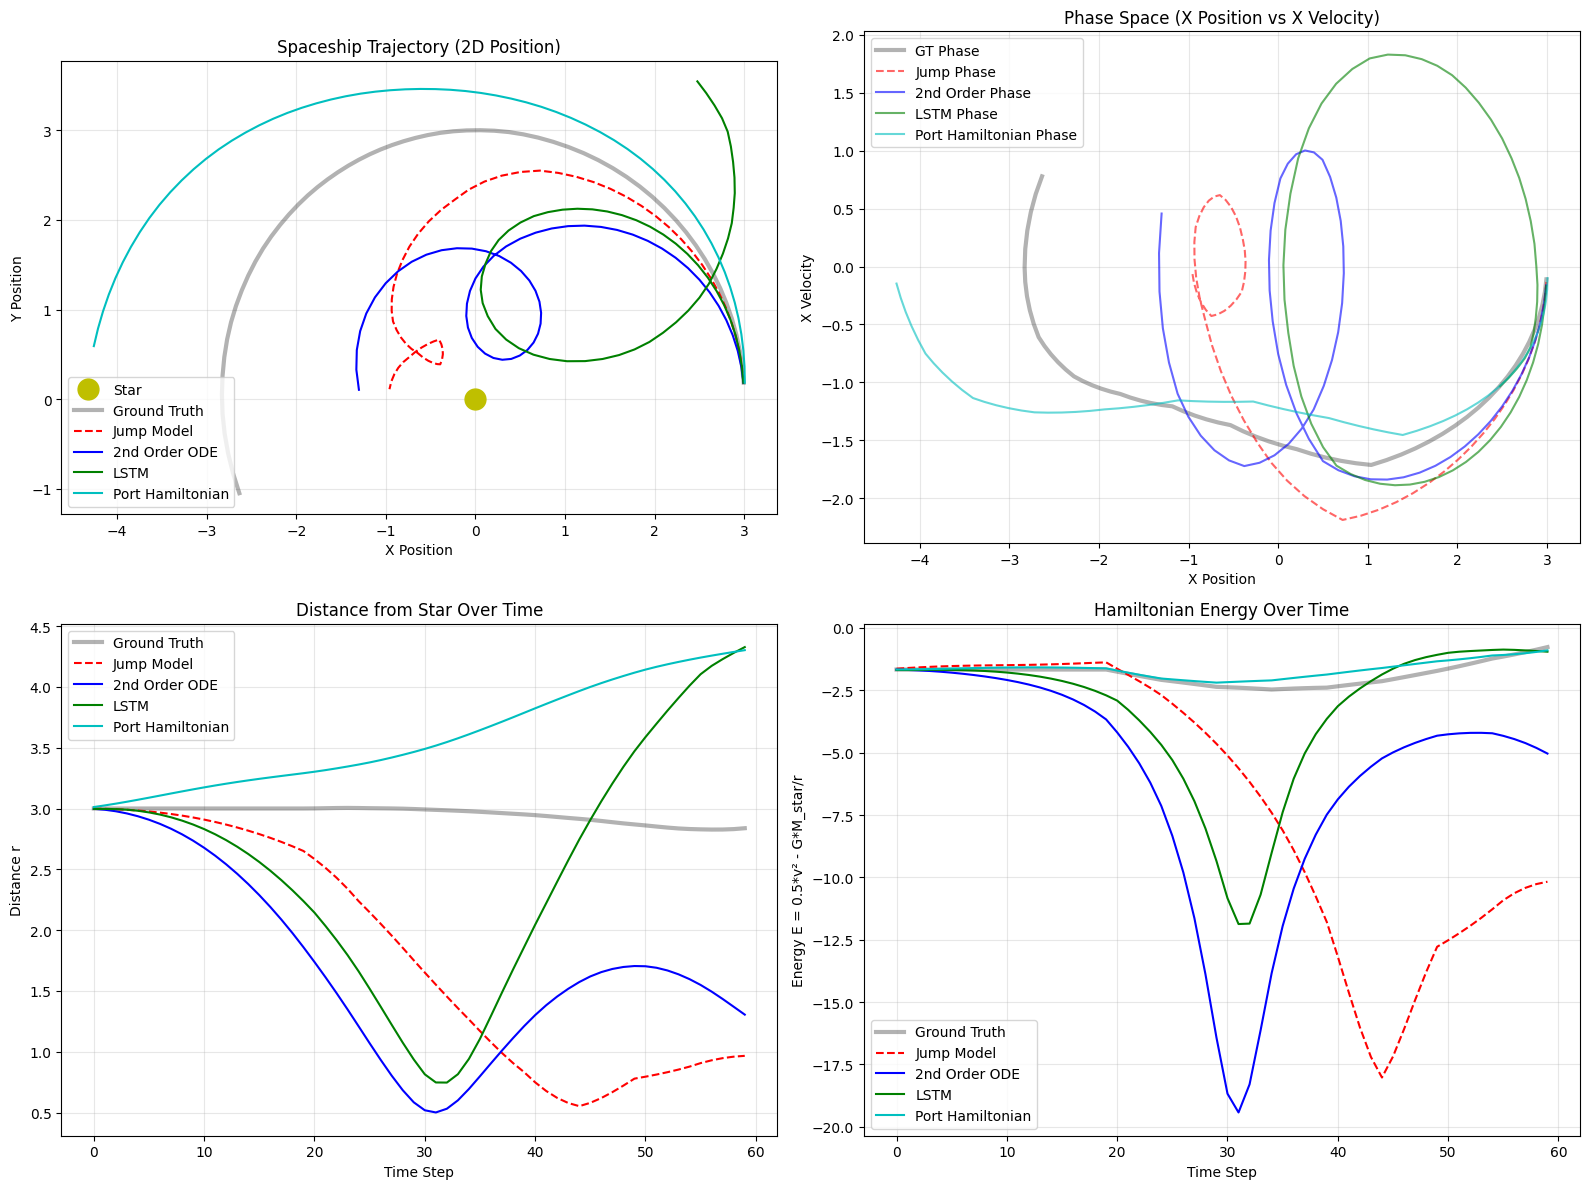

{'ground_truth': array([[ 2.9944458 ,  0.1824615 , -0.11104247,  1.8223623 ],
        [ 2.9778051 ,  0.3642474 , -0.2216739 ,  1.8122355 ],
        [ 2.950139  ,  0.54468524, -0.33148462,  1.7953968 ],
        [ 2.9115503 ,  0.7231058 , -0.44006783,  1.7719122 ],
        [ 2.8621805 ,  0.8988489 , -0.5470216 ,  1.7418667 ],
        [ 2.8022132 ,  1.0712641 , -0.65195   ,  1.7053721 ],
        [ 2.7318707 ,  1.239713  , -0.75446457,  1.662563  ],
        [ 2.651413  ,  1.4035715 , -0.85418564,  1.6135981 ],
        [ 2.5611384 ,  1.5622333 , -0.95074415,  1.558659  ],
        [ 2.4613814 ,  1.7151108 , -1.0437824 ,  1.4979488 ],
        [ 2.352511  ,  1.861638  , -1.1329559 ,  1.4316922 ],
        [ 2.23493   ,  2.0012724 , -1.2179347 ,  1.3601347 ],
        [ 2.109074  ,  2.133497  , -1.298404  ,  1.2835412 ],
        [ 1.9754095 ,  2.2578225 , -1.3740659 ,  1.2021954 ],
        [ 1.8344307 ,  2.373788  , -1.4446402 ,  1.1163985 ],
        [ 1.6866598 ,  2.4809644 , -1.5098656 ,  1.026

In [98]:
# Visualize Spaceship Predictions (trained dt=0.1)
visualize_spaceship_unroll(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
    treatment={0: 20, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5},
    dt=0.1,
    thruster_magnitude=0.5,
)

## Variable dt Generalization Tests

Test how well spaceship models generalize to different time steps than they were trained on (trained on dt=0.1)

### dt = 0.05 (Smaller timestep)

In [ ]:
visualize_spaceship_unroll(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
    treatment={0: 20, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5},
    dt=0.05,
    thruster_magnitude=0.5,
)

### dt = 0.2 (Larger timestep)

In [ ]:
visualize_spaceship_unroll(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
    treatment={0: 20, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5},
    dt=0.2,
    thruster_magnitude=0.5,
)

### dt = 0.5 (Much larger timestep)

In [ ]:
visualize_spaceship_unroll(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
    treatment={0: 20, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5},
    dt=0.5,
    thruster_magnitude=0.5,
)

## Test Set Sample Predictions

Plot position, phase space, distance, and energy for a sample from the test set

In [ ]:
# Plot predictions for test sample 0
plot_spaceship_test_sample(
    spaceship_jump_model,
    spaceship_traj_model,
    spaceship_lstm_model,
    spaceship_port_hamiltonian_model,
    dataset=spaceship_dataset,
    sample_idx=0,
    dt=0.1,
    thruster_magnitude=0.5,
)